# Trabajo 1: Preprocesamiento y evaluación de clasificadores 


**Integrantes del grupo:**

- Monya Tayebi Hillali
- Alicia Jiajun Lorenzo Lourido

### ***Librerías utilizadas***

In [1]:
# base 
import math
import pandas as pd
import numpy as np
import os
# 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mi
#
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
# filtros
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFwe
# wrappers
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV


# resample
from sklearn.utils import resample

# evaluation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold



# Modelos 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Almacenamiento de modelos 
import pickle

# Warnings
import warnings


In [2]:
SEED_VALUE = 28

In [3]:
warnings.simplefilter("ignore")

### ***Carga de datos***

In [4]:
path_data='./data/datos_accidentes_cerebrovasculares.csv'
datos = pd.read_csv(path_data, sep=',')

### **Análisis descriptivo de los datos**

#### ***Información de los datos***

Comenzamos viendo los datos en la tabla ,  el número de filas y columnas de nuestro dataset : 

In [5]:
datos

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Vemos como tenemos los datos de 5110 pacientes y los valores de 11 parámetros de entrada distintos y 1 de salida. 

Con los siguientes métodos modificamos los datos no numéricos a numericos para poder visualizarlos empleando la librería seaborn. Posteriormente se incidirá más en esta cuestión. 

A continuación, se muestran las funciones empleadas para realizar dicha conversión, luego se aplica sobre las columnas de tipo de dato no numérico que podemos ver en la salida anterior.

In [7]:
def get_dict_of_relation_value_and_numeric(dataframe,column):
    return {value:number for number,value in enumerate(dataframe[column].unique())}
def transform_data_of_column_to_numeric(dataframe,column):
    dataframe[column] = dataframe[column].map(get_dict_of_relation_value_and_numeric(dataframe,column)) 
def transform_data_to_numeric(dataframe,column_list):
    for column in column_list:
        transform_data_of_column_to_numeric(dataframe, column)

In [8]:
datos_tranform = datos.copy() 
column_list=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status']
transform_data_to_numeric(datos_tranform, column_list)

In [9]:
datos_tranform.head()

id  gender   age  hypertension  heart_disease  ever_married  work_type  \
0   9046       0  67.0             0              0             0          0   
1  51676       1  61.0             0              1             0          1   
2  31112       0  80.0             0              0             0          0   
3  60182       1  49.0             0              1             0          0   
4   1665       1  79.0             1              1             0          1   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               0             228.69  36.6               0       1  
1               1             202.21   NaN               1       1  
2               1             105.92  32.5               1       1  
3               0             171.23  34.4               2       1  
4               1             174.12  24.0               1       1

Ahora, representaremos por pares todas las variables del dataset:

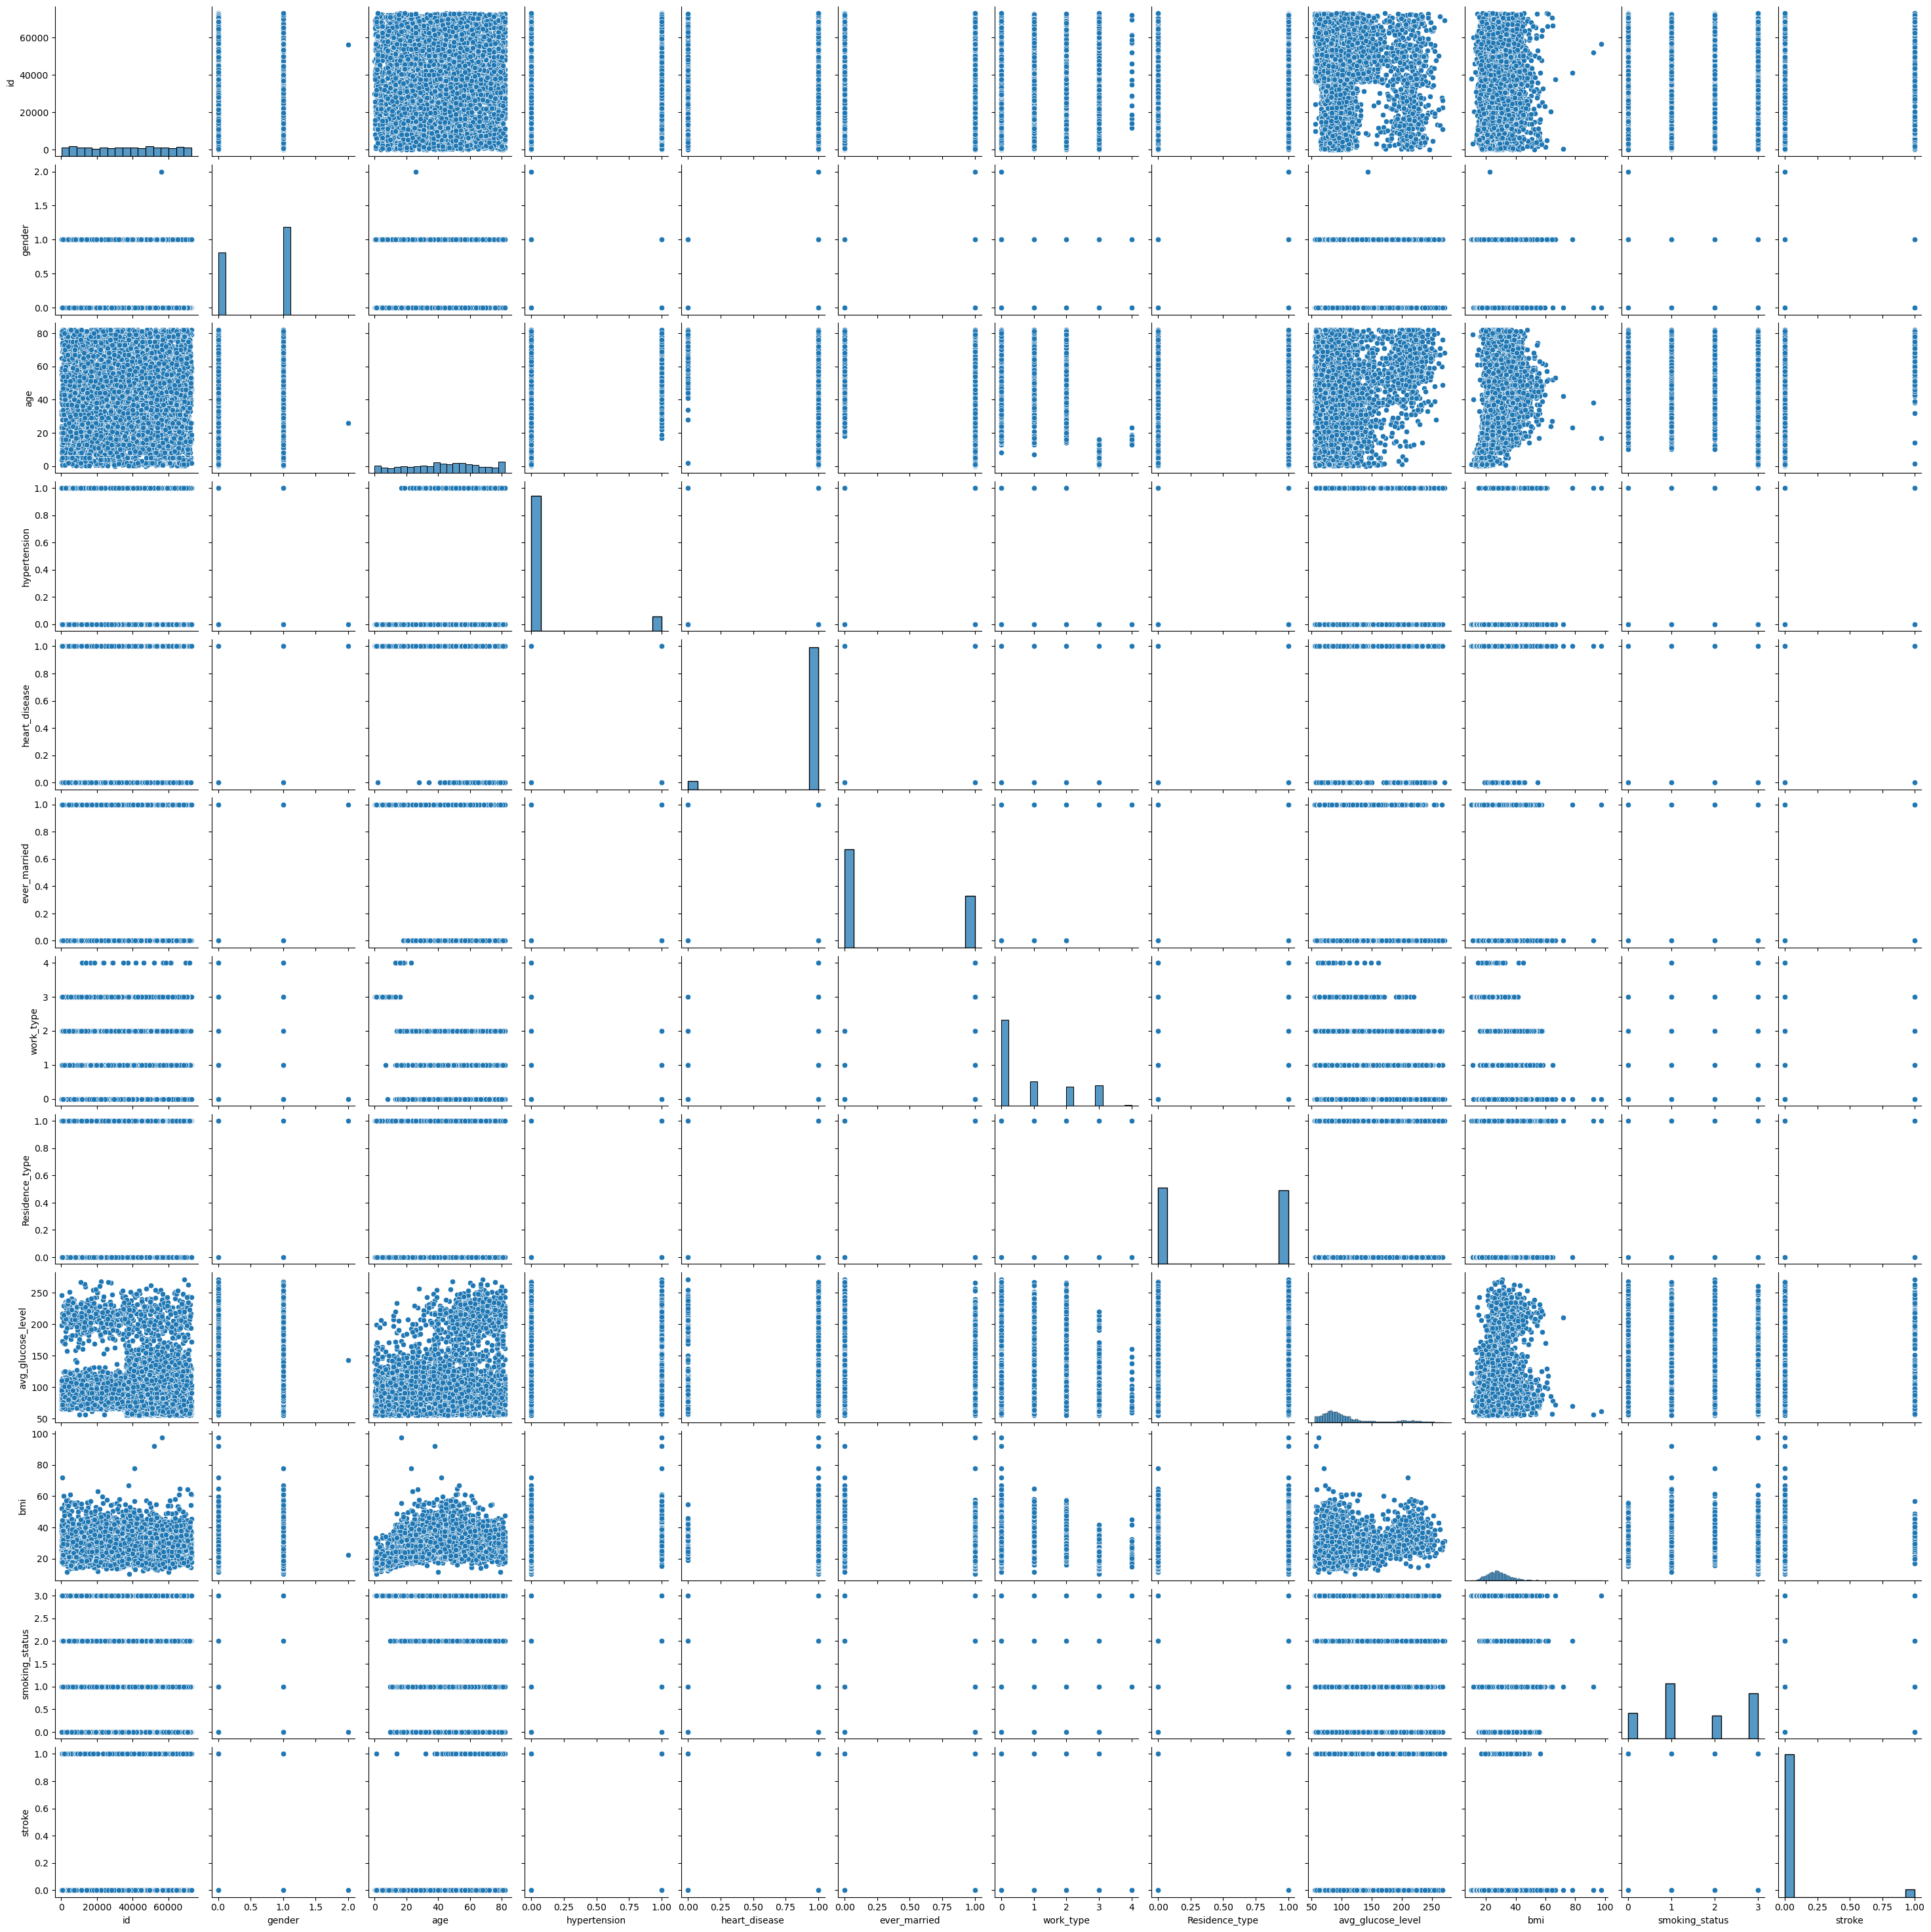

In [10]:
sns.pairplot(datos_tranform)

En este primer gráfico podemos ver como muchos de los sub-gráficos no aportan información clara sobre el conjunto de datos pero sí que podemos destacar la representación de las variables *stroke* y *age* donde vemos que a partir de los 40 años es donde los ataques son más frecuentes así como en el gráfico de los pares de variables *stroke* y *bmi* donde los ataques son más frecuentes para índices de masa corporal entre 20 y 60.

##### ***Información de los atributos***

Comenzaremos representando diferentes gráficos para cada atributo:

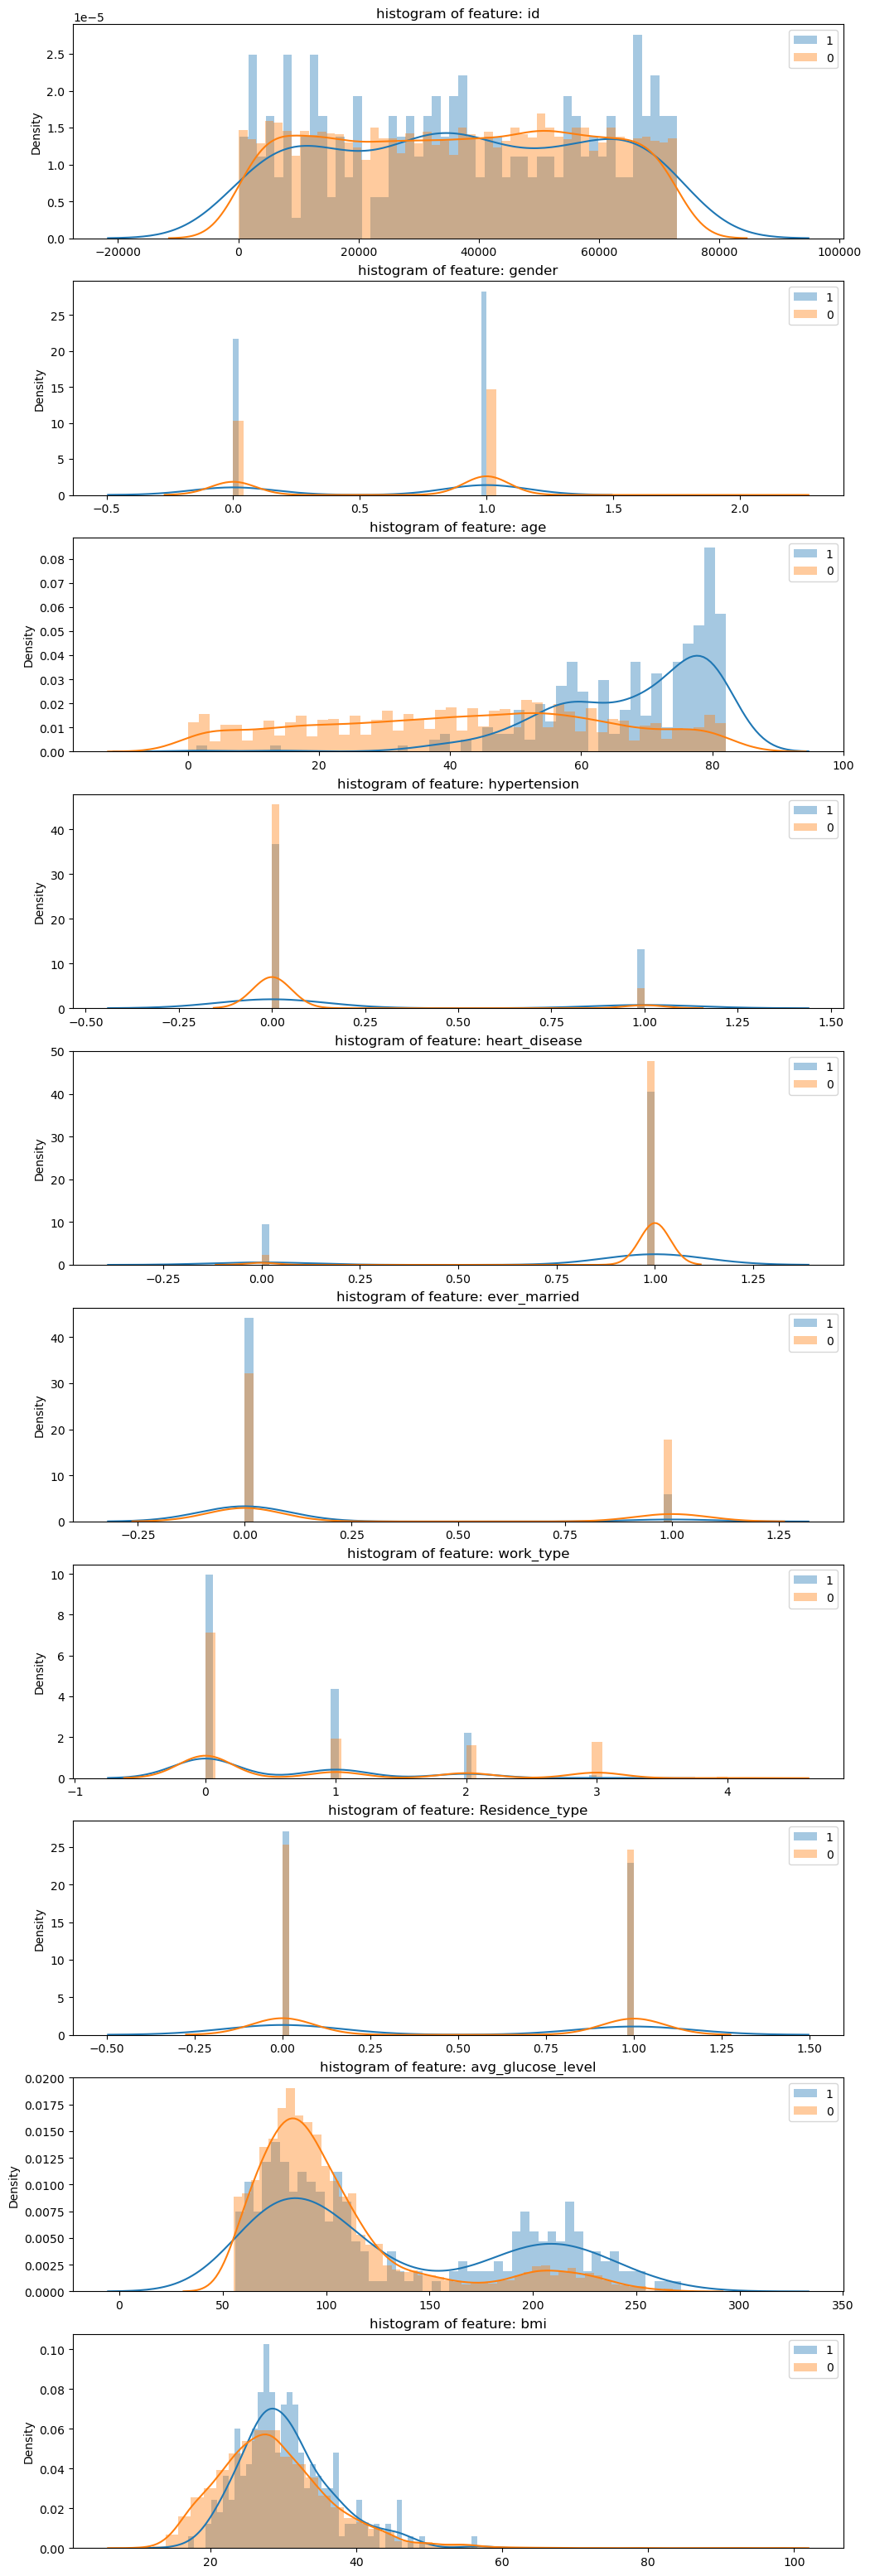

In [11]:
import matplotlib.gridspec as gridspec
columns=datos_tranform.columns[:10]
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datos_tranform[columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(datos_tranform[cn][datos_tranform['stroke'] == 1], bins=50, label='1')
    sns.distplot(datos_tranform[cn][datos_tranform['stroke'] == 0], bins=50, label='0')
    ax.set_xlabel('')
    plt.legend()
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [12]:
def count_unique_values_column(data,column):
    # Verificar si la columna existe en el DataFrame
    if column not in data.columns:
        return "La columna especificada no existe en el DataFrame."
    # Obtener los valores únicos y contar su frecuencia
    unique_values_counts = data[column].value_counts().to_dict()
    return unique_values_counts

def compare_two_columns(data,column_name_1,column_name_2):
    values_uniques_1=data[column_name_1].unique()
    values={}
    for value_unique in values_uniques_1:
        values[value_unique]=count_unique_values_column(data[data[column_name_1]==value_unique],column_name_2)
    return values
def create_dataframe_from_dict(values,column_name_1):
    result_df = pd.DataFrame(values).T.fillna(0).astype(int)
    result_df.index.name = column_name_1
    
    return result_df
def plot_bar_comparative(data,column_name_1,column_name_2='stroke'):
    # Graficar
    data_comparate=compare_two_columns(data,column_name_1,column_name_2)
    print(data_comparate)
    resultado=create_dataframe_from_dict(data_comparate,column_name_1)
    
    resultado.plot(kind='bar')
    plt.title('Comparación de valores de "stroke" por {}'.format(column_name_1))
    plt.xlabel(column_name_1)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=0)
    plt.legend(title='Stroke')
    plt.show()

In [13]:
# Definir función personalizada para pairplot con colores diferenciados por 'stroke'
def custom_pairplot(data, hue):
    sns.set(style="ticks")
    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'})

# Definir función personalizada para pairplot con colores diferenciados por 'stroke' y puntos transparentes
def custom_pairplot_1(data, hue):
    sns.set(style="ticks")
    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'}, plot_kws={'alpha': 0.5})

    
def custom_pairplot_2(data, hue):
    def custom_scatter(x, y, hue, **kwargs):
        plt.scatter(x, y, alpha=0.5 if hue.iloc[0] == 0 else 1, **kwargs)

    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'}, plot_kws={'scatter_kws': {'alpha': 0.5}}, diag_kind='hist', diag_kws={'alpha': 0.5})
    # Sobrescribir la función scatter de seaborn para aplicar alpha condicionalmente
    
def custom_pairplot_3(data, hue):
    def custom_scatter(x, y, hue, **kwargs):
        if hue.iloc[0] == 0:
            kwargs['alpha'] = 0.5
        plt.scatter(x, y, **kwargs)

    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'})
    # Sobrescribir la función scatter de seaborn para aplicar alpha condicionalmente
    for ax in plt.gcf().get_axes():
        ax.scatter = custom_scatter
    


{'Male': {0: 2007, 1: 108}, 'Female': {0: 2853, 1: 141}, 'Other': {0: 1}}


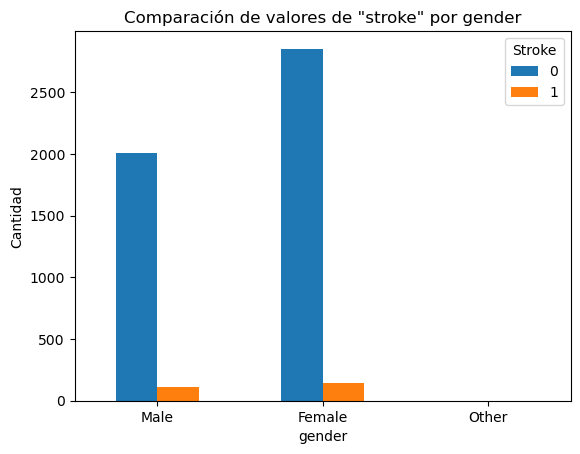

{0: {0: 4429, 1: 183}, 1: {0: 432, 1: 66}}


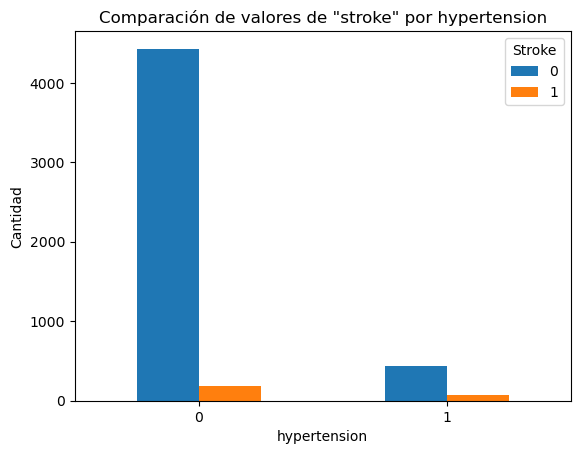

{1: {0: 229, 1: 47}, 0: {0: 4632, 1: 202}}


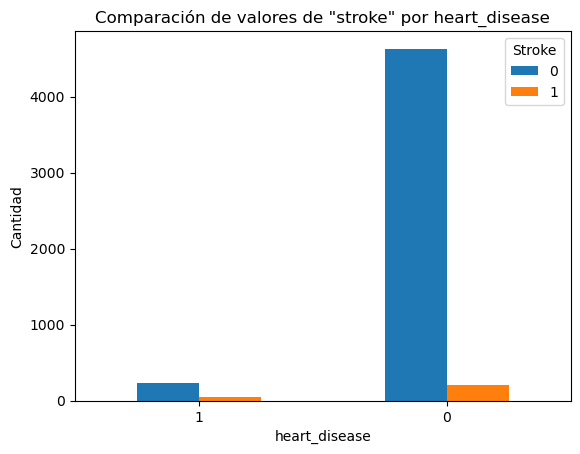

{'Yes': {0: 3133, 1: 220}, 'No': {0: 1728, 1: 29}}


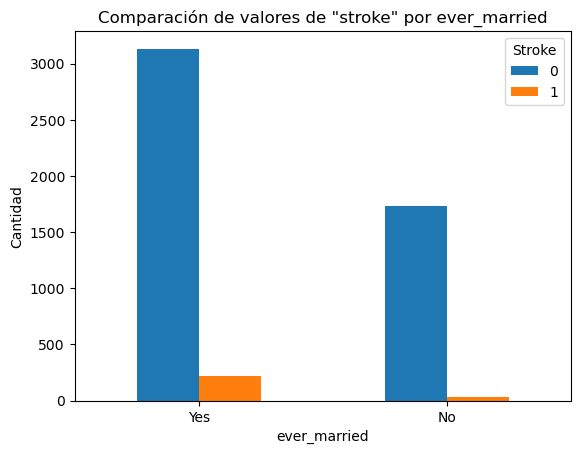

{'Private': {0: 2776, 1: 149}, 'Self-employed': {0: 754, 1: 65}, 'Govt_job': {0: 624, 1: 33}, 'children': {0: 685, 1: 2}, 'Never_worked': {0: 22}}


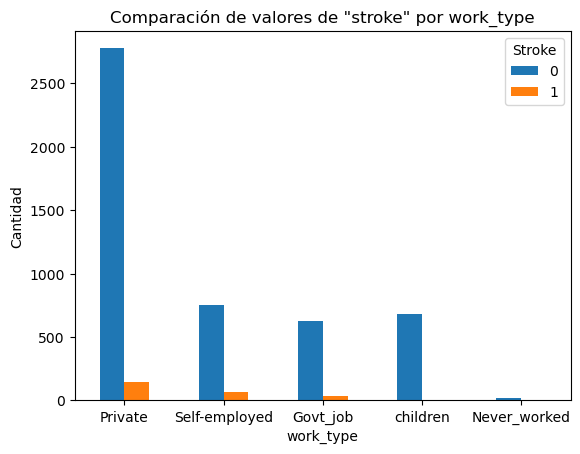

{'Urban': {0: 2461, 1: 135}, 'Rural': {0: 2400, 1: 114}}


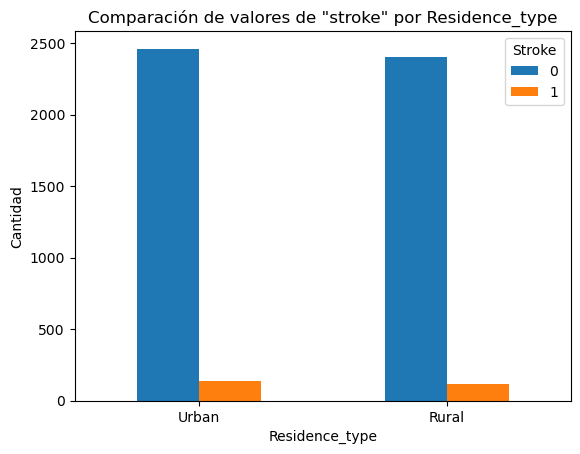

{'formerly smoked': {0: 815, 1: 70}, 'never smoked': {0: 1802, 1: 90}, 'smokes': {0: 747, 1: 42}, 'Unknown': {0: 1497, 1: 47}}


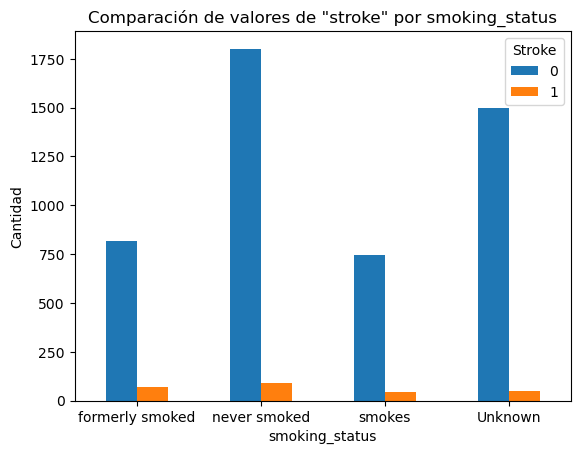

In [14]:
for column in datos.columns:
    if len(datos[column].unique())<10 and column!='stroke':
        plot_bar_comparative(datos,column)

<Figure size 1200x600 with 0 Axes>

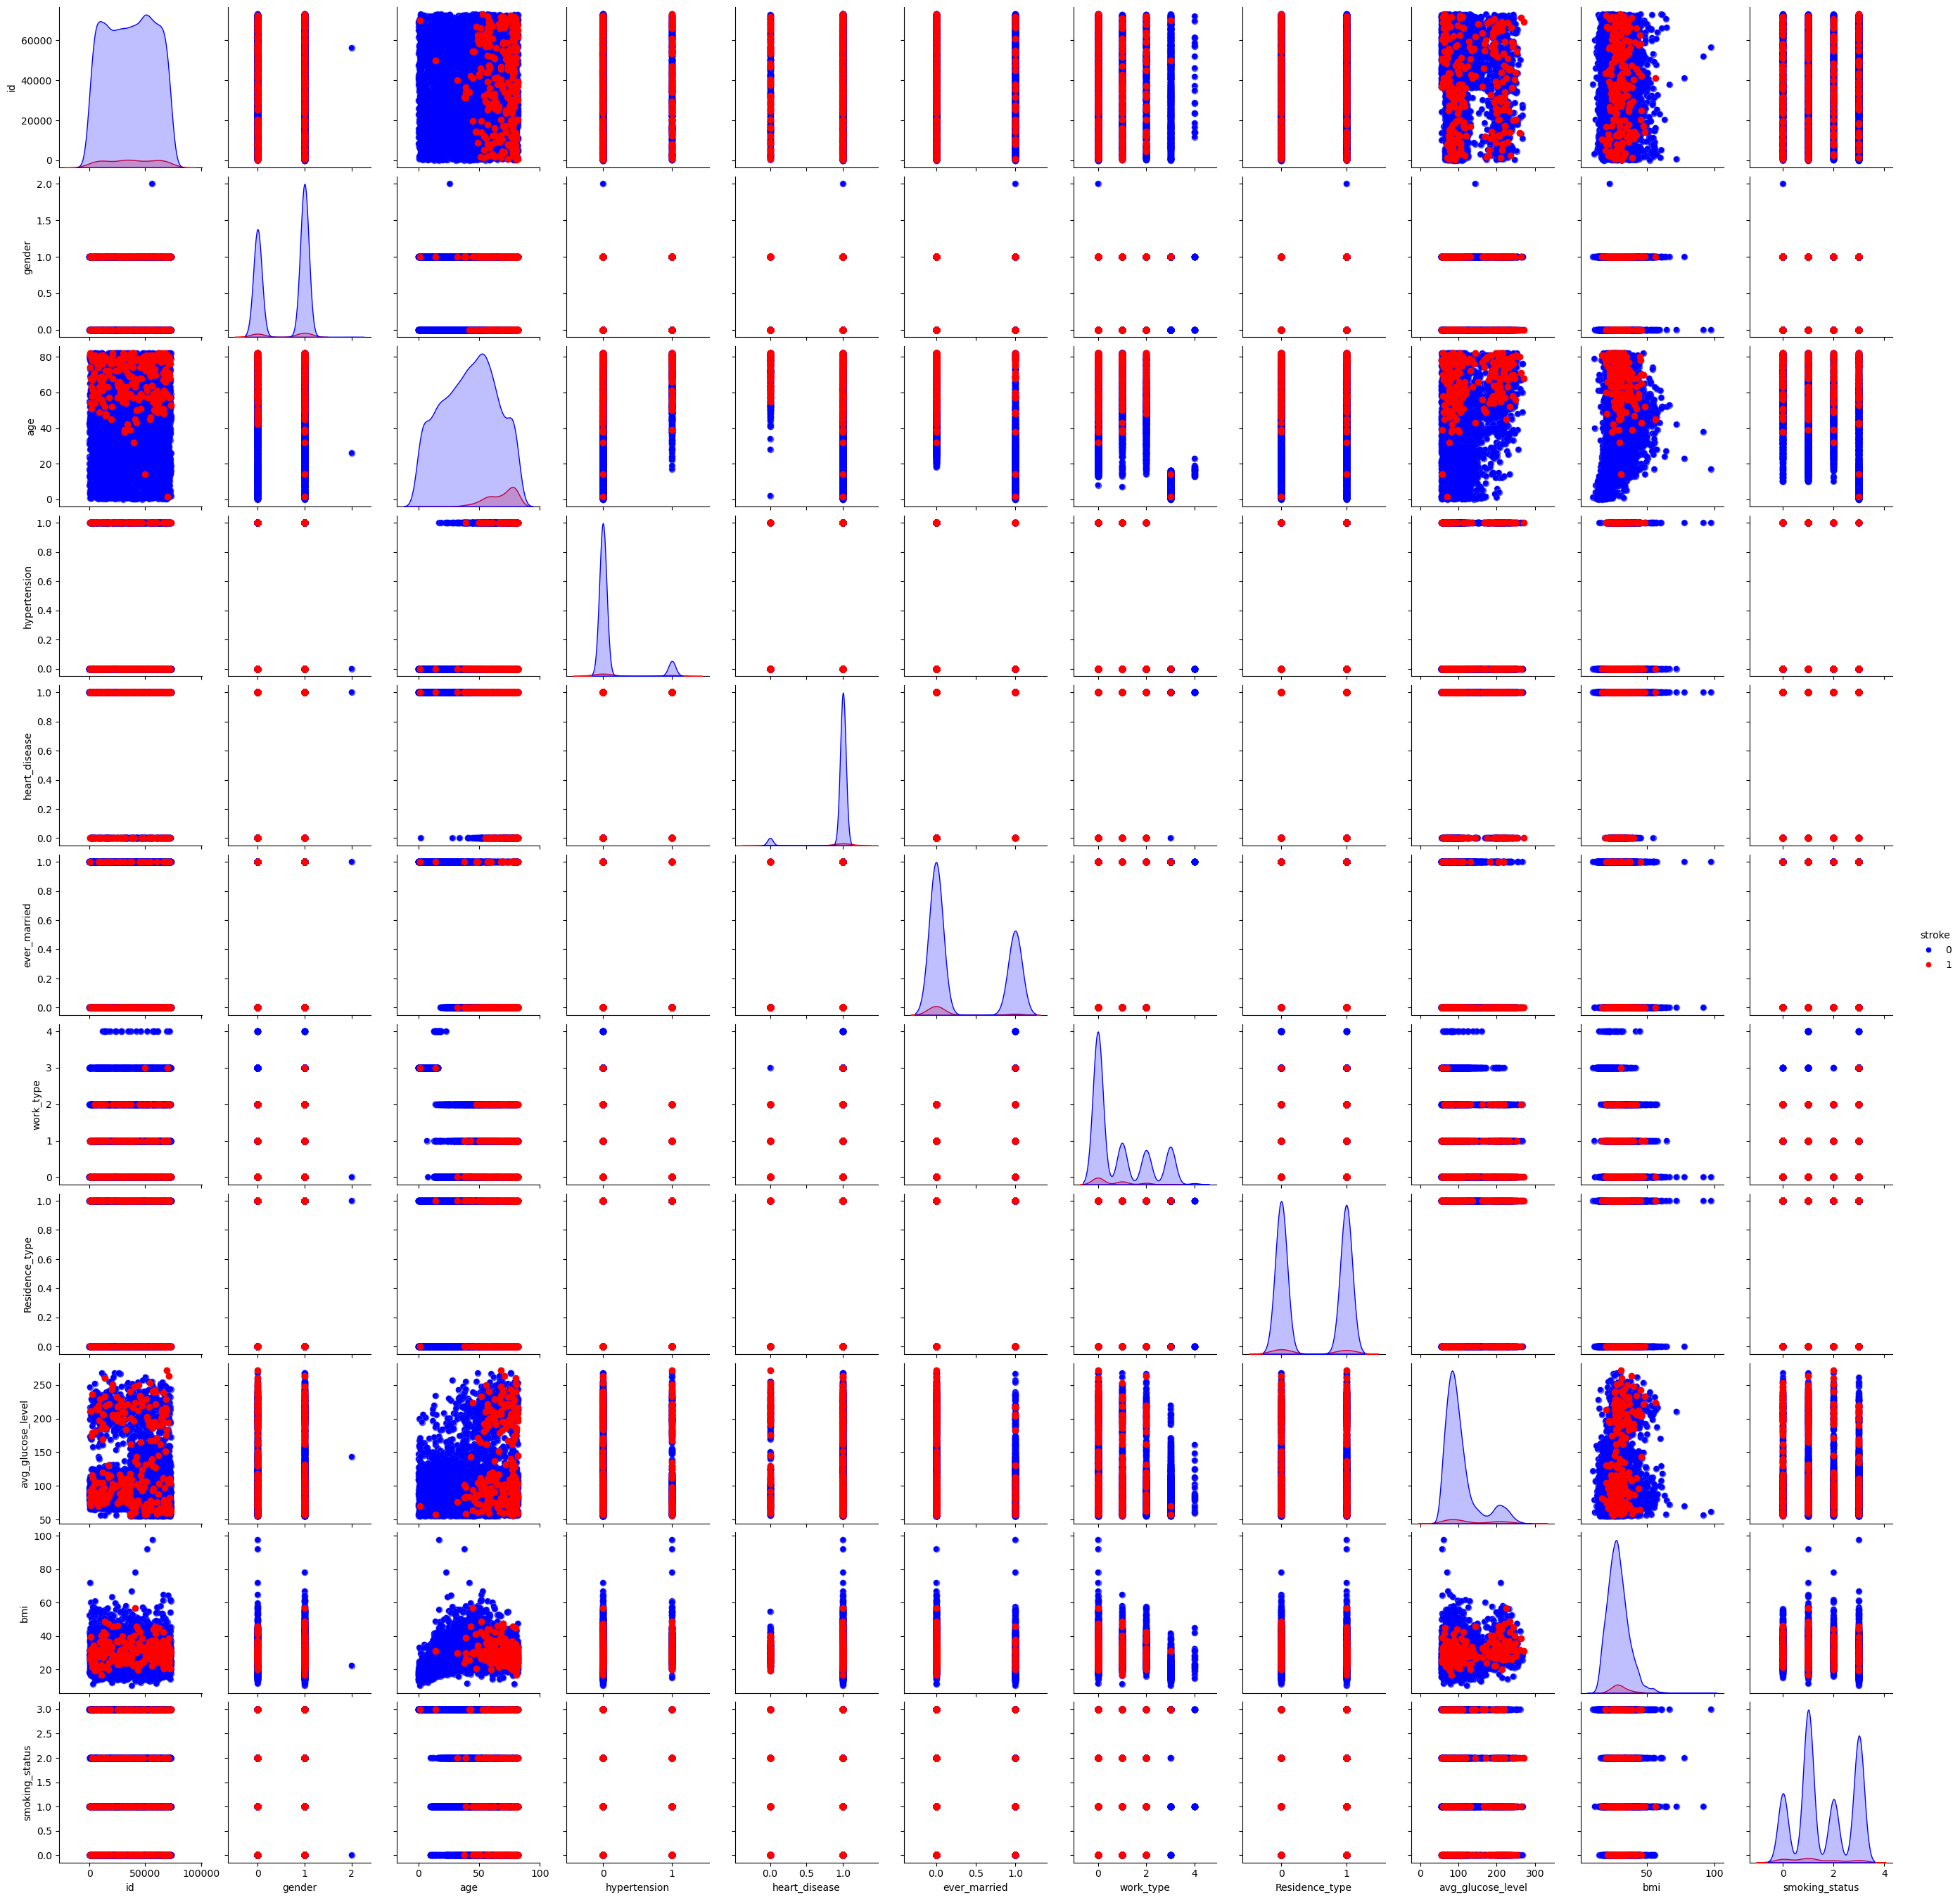

In [15]:
# Graficar
plt.figure(figsize=(12, 6))
# Filtrar datos donde 'stroke' es igual a 0
df_stroke_0 = datos_tranform[datos_tranform['stroke'] == 0]

# Crear pairplot
g = sns.pairplot(data=datos_tranform, hue='stroke', palette={0: 'blue', 1: 'red'})

# Superponer puntos donde 'stroke' es igual a 1 sobre el pairplot
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if i != j:
            g.axes[i, j].scatter(df_stroke_0.iloc[:, j], df_stroke_0.iloc[:, i], c='blue', alpha=0.5, label='Stroke 0')
            g.axes[i, j].scatter(datos_tranform[datos_tranform['stroke'] == 1].iloc[:, j], datos_tranform[datos_tranform['stroke'] == 1].iloc[:, i], c='red', label='Stroke 1')
            #g.axes[i, j].legend()

plt.show()

### Comentario 

Como podemos observar de manera inicial, los casos positivos tienden a superponerse en la mayoría de los casos con los negativos, lo que complica su clasificación en un espacio bidimensional. Sin embargo, al analizar diferentes combinaciones de variables, se destaca que una de las combinaciones más prometedoras podría ser el índice de masa corporal (BMI) junto con la edad (age) algo similar sucede con avg_glucose_level. Esta combinación parece agrupar de manera más efectiva los casos positivos en una sección específica, lo que podría reducir los falsos negativos, una consideración crítica en este contexto. Tambien hay que puede observar que las variables no parecen tener ninguan relación real entre ellas por lo cual ninguna llega a explicar a otra de las varibles . 

Además, parece que las variables relacionadas con el trabajo (work) o el género (gender) pueden ayudar a separar algunas de las superposiciones generadas por la edad (age) y el índice de masa corporal (BMI), lo que podría mejorar la capacidad de clasificación. Por otro lado ever_marriaged parece ser una buena representación para los casos de no  positivos ya que para el caso de no casados hay una cantidad muy reducida de positivos.

Es importante tener en cuenta que los valores de algunas variables están sobremuestreados en comparación con otras, lo que significa que ciertas clases dentro de un atributo puede aparecer con mayor frecuencia que otras. Esto podría permitir comprender grupos más pequeños dentro de los datos. Sin embargo, como se observa en las gráficas, los casos positivos están submuestreados, lo que añade un desafío adicional a la tarea de clasificación.


### ***Preprocesado***

#### ***Gestión de datos ausentes***

En este apartado comprobaremos si hay datos ausentes, y los trataremos.

In [16]:
datos.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

Vemos en la salida anterior que hay valores ausentes y se indican como NaN.

In [17]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Si mostramos la información del dataframe vemos que de las 12 columnas del dataset, solo la columna *bmi* tiene datos faltantes, concretamente 201 elementos faltantes. Otra forma de verlo es usando *isnull().sum()*, como sigue, y vemos como efectivamente solo la columna *bmi* tiene datos faltantes: 

In [18]:
datos.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Podemos representarlo en forma matricial, donde cada fila representa uno de los objetos, y los valores ausentes se representan en blanco, y vemos como se distribuyen los valores ausentes en la columna *bmi*:

<Axes: >

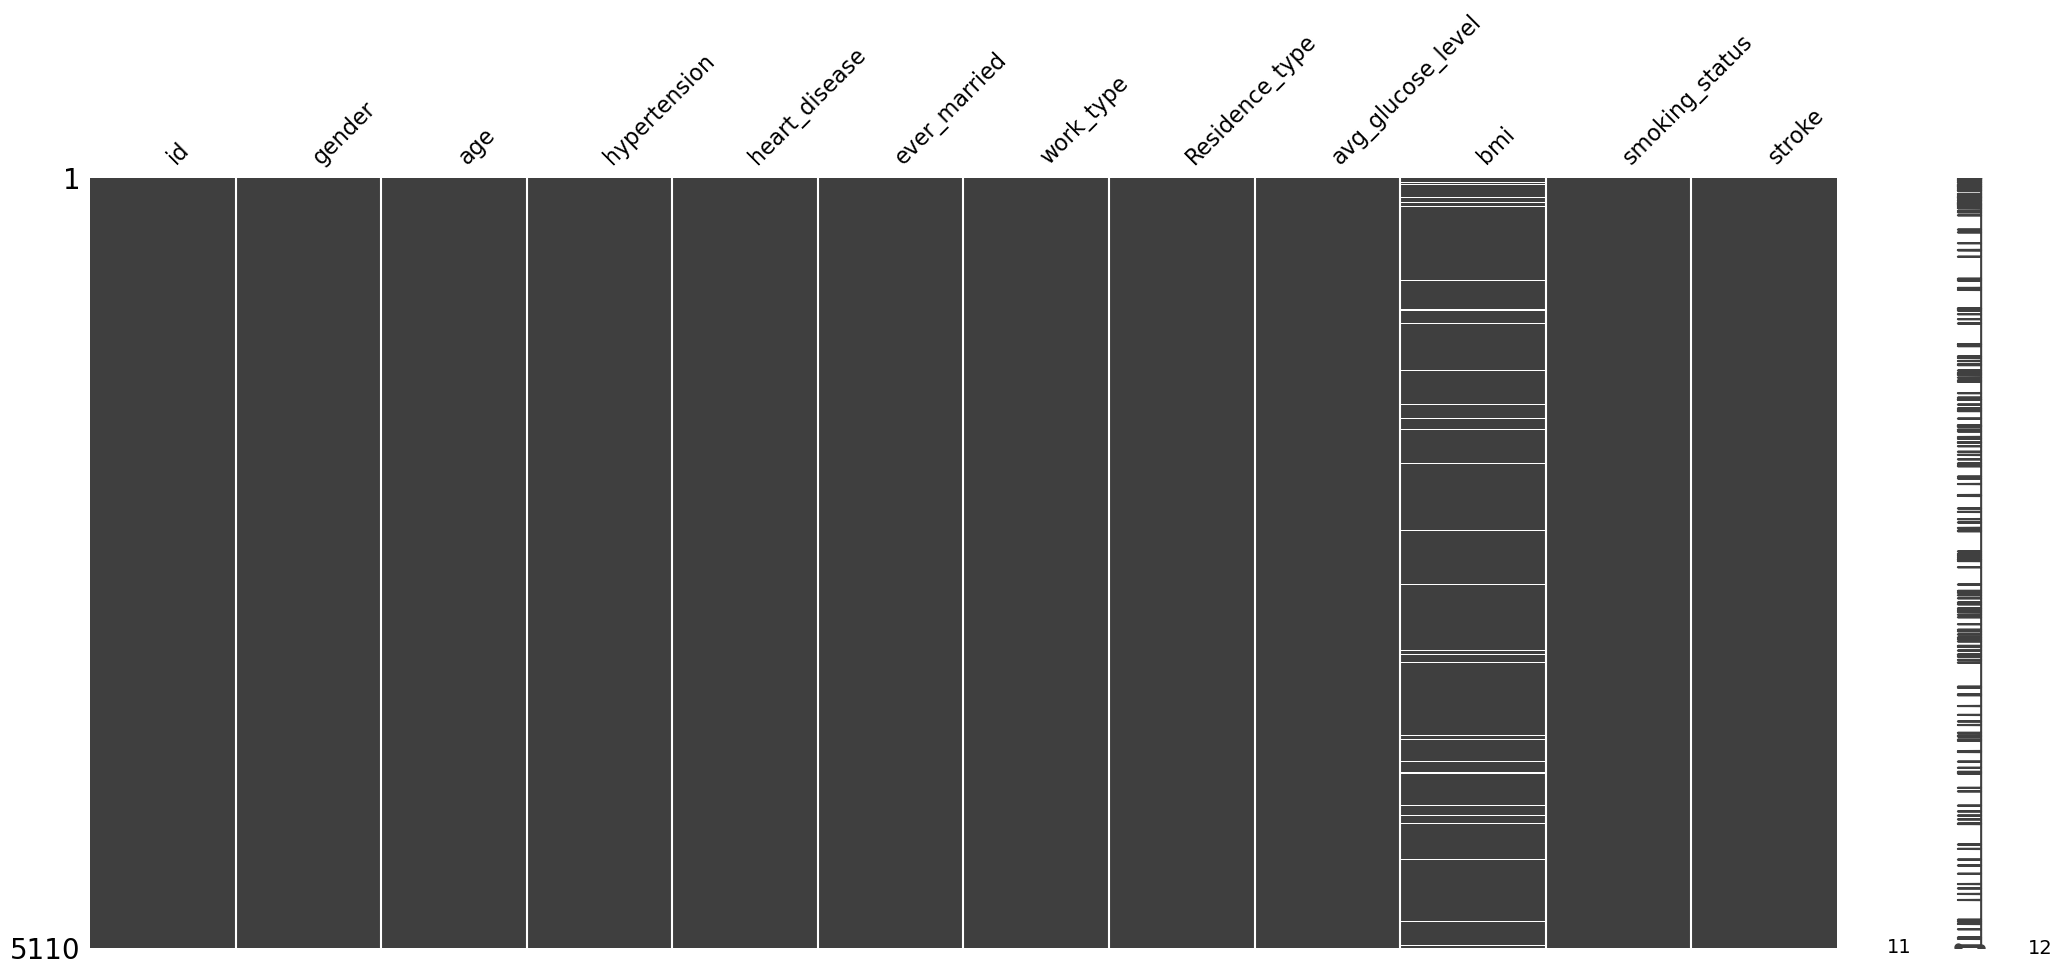

In [19]:
mi.matrix(datos)

A continuación, daremos solución a estos datos ausentes. Como hemos visto, son 201 objetos con el dato de *bmi* faltante sobre un total de 5110, es decir, un 4% aproximadamente de los objetos carecen de valor para este atributo. Al tratarse de un porcentaje bajo podríamos optar por eliminar los objetos pero no lo haremos así, optaremos por su imputación.  

Seguidamente, al tratarse de una variable con datos reales, emplearemos las siguientes estrategias de imputación: media, mediana, valor más frecuente, constante y KNN. 

In [20]:
def imputar_datos(datos, estrategia='mean', fill_value=None, **kwargs):
    """
    Imputa los valores faltantes en un dataframe utilizando diferentes estrategias.

    Parámetros:
    - datos: DataFrame. El dataframe de entrada.
    - estrategia: str. La estrategia de imputación a utilizar ('mean', 'median', 'most_frequent', 'constant', 'knn').
    - fill_value: float o None. El valor de relleno para la estrategia 'constant'.
    - **kwargs: Parámetros adicionales para KNNImputer.

    Retorna:
    - DataFrame. El dataframe con los valores imputados.
    """

    if estrategia == 'knn':
        knni = KNNImputer(**kwargs)
        datos_imputados = datos.copy()
        datos_imputados['bmi'] = knni.fit_transform(datos_imputados['bmi'].values.reshape(-1,1))
    else:
        si = SimpleImputer(strategy=estrategia, fill_value=fill_value)
        datos_imputados = datos.copy()
        datos_imputados['bmi'] = si.fit_transform(datos_imputados['bmi'].values.reshape(-1,1))

    return datos_imputados


def imputar_datos_of_column(datos, estrategias={'mean': None}, **kwargs):
    """
    Imputa los valores faltantes en un dataframe utilizando diferentes estrategias.

    Parámetros:
    - datos: DataFrame. El dataframe de entrada.
    - estrategias: dict. Un diccionario donde las claves son las estrategias de imputación y los valores son los valores de relleno (para la estrategia 'constant') o None.
    - **kwargs: Parámetros adicionales para KNNImputer.

    Retorna:
    - dict. Un diccionario donde las claves son las estrategias de imputación y los valores son los dataframes con los valores imputados.
    """

    datos_imputados = {}

    for estrategia, fill_value in estrategias.items():
           datos_imputados[estrategia]=imputar_datos(datos, estrategia='mean', fill_value=fill_value)
    return datos_imputados


Ahora, procedemos a realizar la imputación de los datos faltantes:

In [21]:
estrategias = {
    'mean': None,
    'median': None,
    'most_frequent': None,
    'constant': 30,
    'knn': {'n_neighbors': 5, 'weights': 'uniform'}
}
datos_imputados_all = imputar_datos_of_column(datos, estrategias=estrategias)

In [22]:
def graficar_imputacion(datos_imputados, null_values):
    """
    Genera gráficos de dispersión con la imputación de datos para cada estrategia.

    Parámetros:
    - datos_imputados: dict. Un diccionario donde las claves son las estrategias de imputación y los valores son los dataframes con los valores imputados.
    - estrategias: list. Una lista de las estrategias de imputación.
    - null_values: Series. Una serie de valores booleanos indicando los valores nulos en los datos originales.

    Retorna:
    - None.
    """

    for estrategia in datos_imputados.keys():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(datos_imputados[estrategia]["age"], datos_imputados[estrategia]["bmi"], c=null_values, cmap='winter')
        ax.set_title(estrategia + ' Imputation')
        plt.colorbar(ax.scatter(datos_imputados[estrategia]["age"], datos_imputados[estrategia]["bmi"], c=null_values, cmap='winter'))
        plt.show()

Una vez realizada la imputación, comparemos gráficamente los diferentes métodos de imputación mediante los siguientes gráficos de dispersion: 

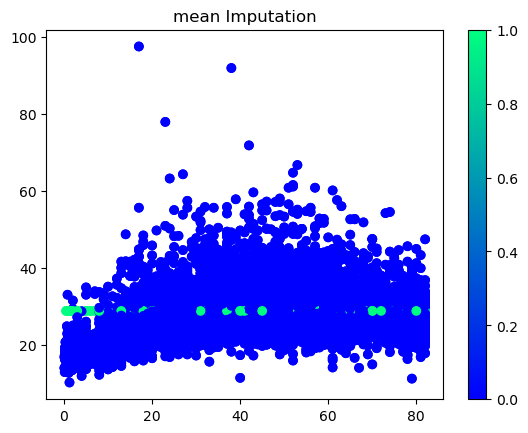

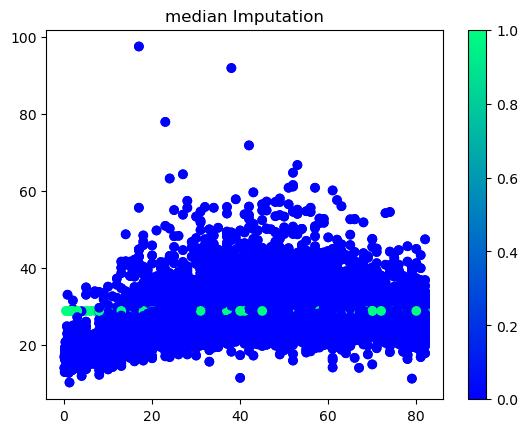

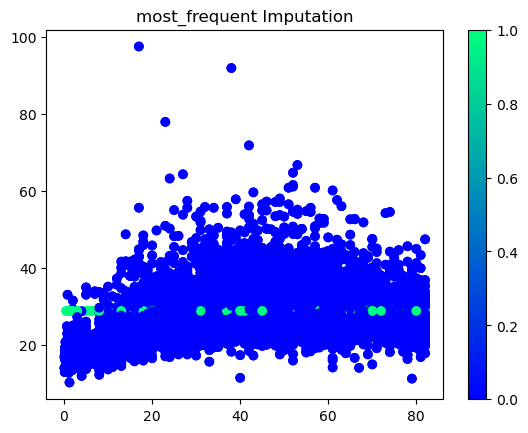

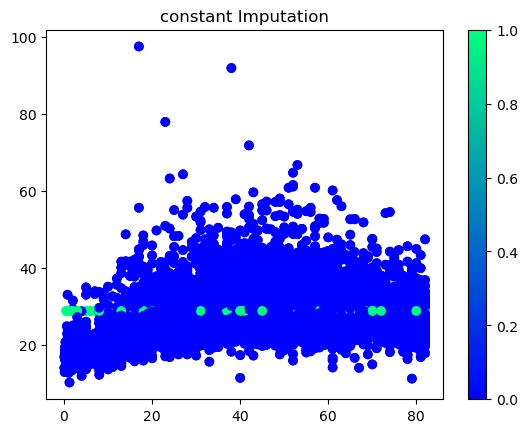

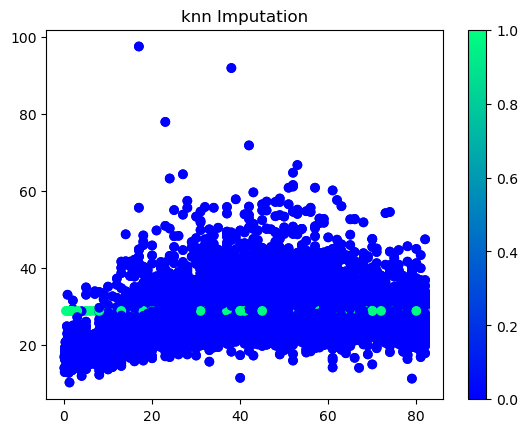

In [23]:
null_values = datos['bmi'].isnull()

graficar_imputacion(datos_imputados_all, null_values)

Finalmente, vemos como en las gráficas anteriores no existe ninguna diferencia notoria por lo que se seleccionará una de las estrategias posteriormente para continuar con el resto de los apartados. 

In [24]:
datos_imputados = datos_imputados_all['mean']

#### ***Transformación de datos***

El objetivo de la presente sección es el de hacer los cambios en los datos que nos permitan continuar con el resto de los apartados. Vemos a continuación como en el dataframe hay atributos que son de tipo de dato int64, otros float64 miemtras que el resto son de tipo object:

In [25]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Como hemos visto anteriormente, los datos de tipo object son datos de tipo texto pero ya que los métodos que aplicaremos posteriormente, en ocasiones no soportan datos de tipo texto, procederemos a realizar una codificación one-hot para estos casos. Por lo tanto, también cambiaremos el tipo de dato de dichas columnas de object a int64. 

Asimismo, debemos transformar la variable de salida *stroke* para que pase de ser de tipo de dato *int64* a *category* ya que usaremos posteriormente modelos de clasificación. Además, en lugar de utilizar el 0 y el 1 como representaciones de las dos clases existentes, los sustimos por 'No' y 'Yes', respectivamente. También, para ser más correctos, las variables donde los posibles valores son 0 o 1 las transformaremos a booleanas. 

In [26]:
# Función para cambiar la representación de la variable de salida
def tranform_column_stroke(datos):
    datos['stroke'].mask(datos['stroke'] == 0, 'No', inplace=True)
    datos['stroke'].mask(datos['stroke'] == 1, 'Yes', inplace=True)

# Función para cambiar el tipo de dato de cada columna al adecuado
def transform_column_type(datos):
    datos['gender'] = datos['gender'].astype('int64')
    datos['hypertension'] = datos['hypertension'].astype('boolean')
    datos['heart_disease'] = datos['heart_disease'].astype('boolean')
    datos['ever_married'] = datos['ever_married'].astype('boolean')
    datos['work_type'] = datos['work_type'].astype('int64')
    datos['Residence_type'] = datos['Residence_type'].astype('int64')
    datos['smoking_status'] = datos['smoking_status'].astype('int64')
    datos['stroke'] = datos['stroke'].astype('category')

# Función para aplicar las transformaciones al dataframe de cada estrategia de imputación
def transform_all_data(datos, column_list=[]):
    tranform_column_stroke(datos)
    transform_data_to_numeric(datos, column_list)
    transform_column_type(datos)
    return datos

Ahora, aplicamos las transformaciones a los datos:

In [27]:
column_list=['gender','ever_married','work_type','Residence_type','smoking_status']
datos_transform = transform_all_data(datos_imputados, column_list=column_list)

In [28]:
datos_transform.head()

id  gender   age  hypertension  heart_disease  ever_married  work_type  \
0   9046       0  67.0         False           True         False          0   
1  51676       1  61.0         False          False         False          1   
2  31112       0  80.0         False           True         False          0   
3  60182       1  49.0         False          False         False          0   
4   1665       1  79.0          True          False         False          1   

   Residence_type  avg_glucose_level        bmi  smoking_status stroke  
0               0             228.69  36.600000               0    Yes  
1               1             202.21  28.893237               1    Yes  
2               1             105.92  32.500000               1    Yes  
3               0             171.23  34.400000               2    Yes  
4               1             174.12  24.000000               1    Yes

Comprobamos a continuación los nuevos tipos de datos de las columnas: 

In [29]:
datos_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   int64   
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   boolean 
 4   heart_disease      5110 non-null   boolean 
 5   ever_married       5110 non-null   boolean 
 6   work_type          5110 non-null   int64   
 7   Residence_type     5110 non-null   int64   
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                5110 non-null   float64 
 10  smoking_status     5110 non-null   int64   
 11  stroke             5110 non-null   category
dtypes: boolean(3), category(1), float64(3), int64(5)
memory usage: 354.6 KB


#### ***Estandarización de datos***

En este apartado, comenzaremos dividiendo los datos en entrenamiento y en test para luego aplicar la estandarización sobre los datos. 
Seguidamente, daremos solución al desbalanceo de las clases del dataset que hemos visto en secciones anteriores.


Comenzamos estandarizando los datos:

In [ ]:
# Función que realiza la estandarización
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Función para dividir los datos en entrenamiento y test
def split_data(data, column_y='stroke', test_size=0.2, random_state=SEED_VALUE):
    X = data.drop(column_y, axis=1)
    y = data[column_y]
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Función que realiza la estandarización
def standardize_train_test_split(train_data, test_data):
    columns_to_scale = train_data.select_dtypes(include=['float64']).columns
    X_train_scaled, X_test_scaled = standardize_data(train_data[columns_to_scale], test_data[columns_to_scale])
    train_data[columns_to_scale] = X_train_scaled
    test_data[columns_to_scale] = X_test_scaled
    return train_data, test_data

# Función para dividir los datos y estandarizar 
def standardize_all_strategies(data, column_y='stroke', test_size=0.2, random_state=SEED_VALUE):
    standardized_data = {}
    for strategy, dataset in data.items():
        X_train, X_test, y_train, y_test = split_data(dataset, column_y=column_y, test_size=test_size, random_state=random_state)
        X_train_standardized, X_test_standardized = standardize_train_test_split(X_train, X_test)
        standardized_data[strategy] = {
            'X_train': X_train_standardized,
            'y_train': y_train,
            'X_test': X_test_standardized,
            'y_test': y_test
        }
    return standardized_data

In [ ]:
data_to_standarice={'a':datos_transform}
data_standarized = standardize_all_strategies(data_to_standarice.copy())

Ahora, veamos el desbalanceo:

In [ ]:
print(datos_transform['stroke'].value_counts())
datos_transform['stroke'].value_counts().plot(kind='bar')

Vemos que aproximadamente el 95% de los datos son de la clase 'No' o 0, es decir, la mayoría de los pacientes no han tenido ningún ataque. Esta es una situación clara de desbalanceo de clases la cual solucionaremos utilizando dos técnicas de muestreo: up-sampling y down-sampling. Utilizaremos ambas técnicas en los apartados posteriores para contrastar la diferencia entre los resultados que produce cada una de ellas. 

In [ ]:
# Función que hace el remuestreo
def resample_data(datos, column,fill_value=[]):
    datos1 = datos[datos[column] == fill_value[0]]
    datos2  = datos[datos[column] == fill_value[1]]

    datos3 = resample(datos2, replace=True, n_samples=len(datos1), random_state=SEED_VALUE)

    data_resampled = pd.concat([datos3, datos1])
    return data_resampled

# Función que selecciona los datos de entrenamiento y les aplica el remuestreo
def resample_data_data(datos, column, fill_value=[],key='a',column_y='stroke'):
    datos=datos[key].copy()
    traindata=pd.concat([datos['X_train'],datos['y_train']], axis=1)
    data_resample=resample_data(traindata, column, fill_value=fill_value)
    X = data_resample.drop(column_y, axis=1)
    y = data_resample[column_y]
    datos['X_train']=X
    datos['y_train']=y
    return datos
    
def resample_data_of_column(datos, column='stroke', estrategias = {'downsample': 0, 'upsample': -1}, in_dict=False):
    """
    Balancea las clases en el conjunto de datos usando dos estrategias 

    Parámetros:
    - datos: DataFrame. El dataframe de entrada.
    - estrategias: dict. Un diccionario donde las claves son las estrategias de balanceo de clases
    - **kwargs: Parámetros adicionales.

    Retorna:
    - dict. Un diccionario donde las claves son las estrategias de balanceo y los valores son los dataframes balanceados.
    """

    datos_estandarice = {}

    for estrategia, fill_value in estrategias.items():
        if in_dict:
            datos_estandarice[estrategia] = resample_data_data(datos.copy(), column, fill_value=fill_value)
        else:
            
            datos_estandarice[estrategia] = resample_data(datos.copy(), column, fill_value=fill_value)
        
    return datos_estandarice



In [ ]:
estrategias_sample = {
    'downsample': ['Yes','No'],
    'upsample': ['No','Yes'],
}
data_standarized = resample_data_of_column(data_standarized, column='stroke', estrategias = estrategias_sample,
                                           in_dict=True)

Hecho esto, tendremos dos dataframes que utilizaremos en los siguientes apartados: 'downsample' y 'upsample'. Veamos como se ve la distribución de los datos en cada clase en los dos dataframes:

In [ ]:
print(data_standarized['downsample']['X_train'].shape)
data_standarized['downsample']['y_train'].value_counts().plot(kind='bar')

In [ ]:
print(data_standarized['upsample']['X_train'].shape)
data_standarized['upsample']['y_train'].value_counts().plot(kind='bar')

Vemos como ahora tenemos la misma cantidad de datos para cada clase. 

En la siguiente figura se muestra el conjunto de test todavía desbalanceado ya que no se ha aplicado el remuestreo sobre él. 

In [ ]:
data_standarized['downsample']['y_test'].value_counts().plot(kind='bar')

#### ***Selección de variables***

En esta sección realizaremos pruebas con diferentes métodos de selección de variables. Comenzamos con la selección de características basada en filtros:

In [47]:
def feature_selection(X_train, y_train, method, name):
    if name != 'RFE' and name != 'RFECV':
        X_new = method.fit_transform(X_train, y_train)
        mask = method.get_support()
        selected_features = X_train.columns[mask]

        print(f'\n{name}:')
        print(f'Tamaño del conjunto de variables seleccionadas: {X_new.shape}')
        print("Características seleccionadas: ", selected_features.values)
        return selected_features

def feature_selection_plot(X_train,y,methods):
    # Gráficos de las puntuaciones univariadas
    plt.figure(figsize=(10, 6))
    X_indices = np.arange(X_train.shape[-1])
    infinite_value=''
    for name, method in methods.items():
            
         # RFE y RFECV
        if 'RFE' in name:
            svc = SVC(kernel="linear", C=1)
            rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
            rfe.fit(X_train, y)
            ranking_rfe = rfe.ranking_
            plt.bar(X_indices + (len(methods) * 0.15) - 0.2, ranking_rfe, width=0.15, label='RFE')

        elif 'RFECV' in name:
            cv = StratifiedKFold(5)
            svc = SVC(kernel="linear", C=1)
            rfecv = RFECV(estimator=svc, step=1, cv=cv, scoring="accuracy", min_features_to_select=1, n_jobs=-1)
            rfecv.fit(X_train, y)
            ranking_score=rfecv.grid_scores_
            plt.bar(X_indices + ((len(methods) + 1) * 0.15) - 0.2,ranking_score , width=0.15, label='RFECV')
        
        elif name != "VarianceThreshold":
            scores = -np.log10(method.pvalues_)
            scores /= scores[scores != np.inf].max()
            plt.bar(X_indices + (list(methods.keys()).index(name) * 0.2) - 0.05, scores, width=0.2, label=name)
            infinite_value=f' value in {scores}'

    plt.title(f"Puntuación univariada de características \n {infinite_value}")
    plt.xlabel("Número de característica")
    plt.ylabel("Puntuación univariada ($-Log(p_{value})$)")
    plt.legend(loc='upper right')
    plt.show()

def feature_selection_comparison(X_train, y_train,methods):
    
    selected_features = {}
    
    for name, method in methods.items():
       
        selected_features[name] = feature_selection(X_train, y_train, method ,name )
        
    
    # Comprobación de igualdad entre los arrays de características seleccionadas
    #if all(selected_features[key].equals(selected_features["SelectKBest"]) for key in selected_features):
    #    print("\nLos 4 arrays son iguales.")
    #else:
    #    print("\nLos arrays no son iguales.")
    
    feature_selection_plot(X_train,y_train,methods)
    
def feature_selection_all(data,methods):
    #feature_selection=[]
    for strategy, dataset in data.items():
        print(strategy)
        feature_selection_comparison(dataset['X_train'].copy(), dataset['y_train'].copy(), methods)

downsample

VarianceThreshold:
Tamaño del conjunto de variables seleccionadas: (398, 9)
Características seleccionadas:  ['id' 'gender' 'age' 'ever_married' 'work_type' 'Residence_type'
 'avg_glucose_level' 'bmi' 'smoking_status']

SelectKBest:
Tamaño del conjunto de variables seleccionadas: (398, 10)
Características seleccionadas:  ['id' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']

SelectPercentile:
Tamaño del conjunto de variables seleccionadas: (398, 6)
Características seleccionadas:  ['age' 'hypertension' 'heart_disease' 'ever_married' 'avg_glucose_level'
 'smoking_status']

SelectFpr:
Tamaño del conjunto de variables seleccionadas: (398, 6)
Características seleccionadas:  ['age' 'hypertension' 'heart_disease' 'ever_married' 'avg_glucose_level'
 'smoking_status']

SelectFwe:
Tamaño del conjunto de variables seleccionadas: (398, 5)
Características seleccionadas:  ['age' 'hypertension' 'heart_disease' 'e

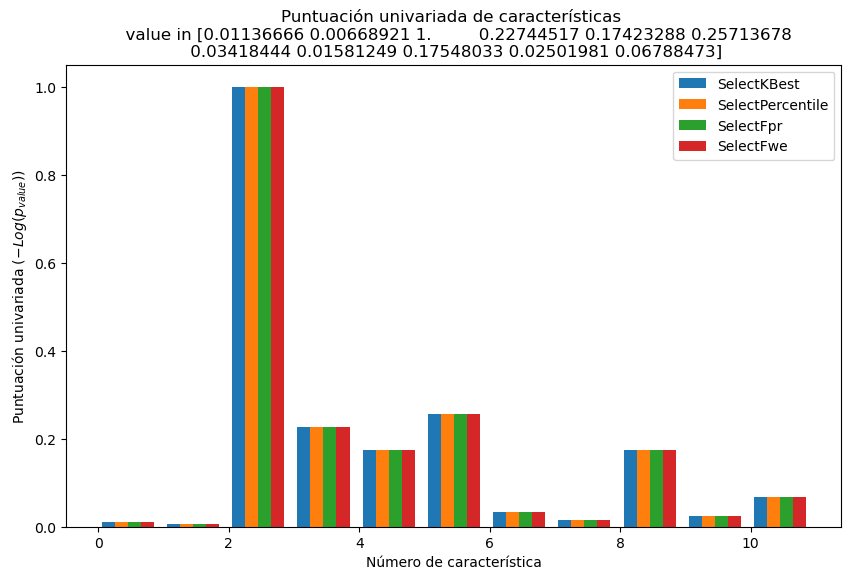

upsample

VarianceThreshold:
Tamaño del conjunto de variables seleccionadas: (7778, 9)
Características seleccionadas:  ['id' 'gender' 'age' 'ever_married' 'work_type' 'Residence_type'
 'avg_glucose_level' 'bmi' 'smoking_status']

SelectKBest:
Tamaño del conjunto de variables seleccionadas: (7778, 10)
Características seleccionadas:  ['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']

SelectPercentile:
Tamaño del conjunto de variables seleccionadas: (7778, 6)
Características seleccionadas:  ['age' 'hypertension' 'heart_disease' 'ever_married' 'avg_glucose_level'
 'smoking_status']

SelectFpr:
Tamaño del conjunto de variables seleccionadas: (7778, 10)
Características seleccionadas:  ['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']

SelectFwe:
Tamaño del conjunto de variables seleccionadas: (7778, 9)
Características sele

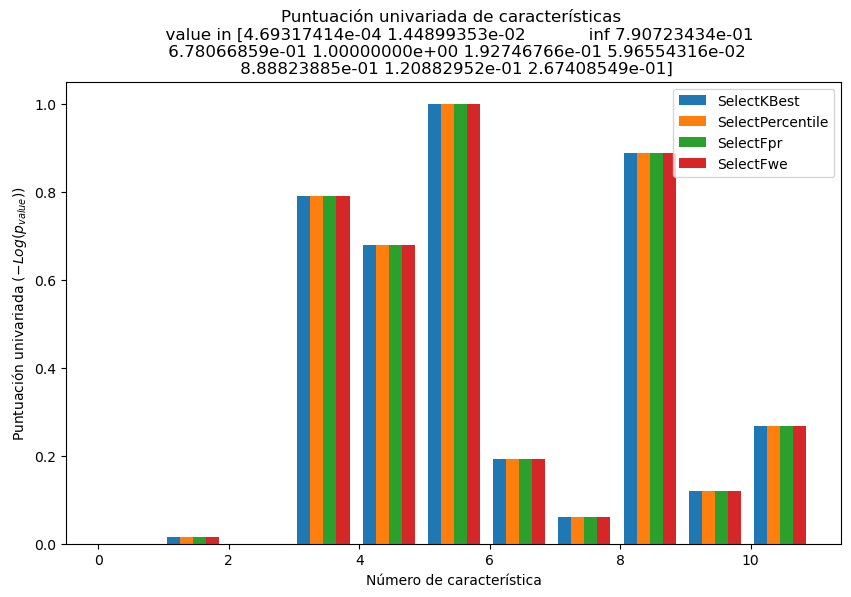

In [48]:
methods = {
        "VarianceThreshold": VarianceThreshold(threshold=(.8 * (1 - .8))),
        "SelectKBest": SelectKBest(f_classif, k=10),
        "SelectPercentile": SelectPercentile(f_classif, percentile=60),
        "SelectFpr": SelectFpr(f_classif, alpha=0.05),
        "SelectFwe": SelectFwe(f_classif, alpha=0.05),
    }
    
feature_selection_all(data_standarized,methods)

### Comentario 

Se observa que diversas estrategias muestran resultados similares, lo que sugiere que pueden ser intercambiables para obtener las mejores variables. En este contexto, las barras más altas en la gráfica indican una mejor variable. Si el valor es infinito, no se representa en la gráfica, pero se menciona en el título a qué valor hace referencia. Posteriormente, procederemos a analizar la combinación de varias variables en secuencia para verificar su efectividad, basándonos en el orden de importancia asignado a las variables siempre manteniendo las mas importantes que la nueva selecionada.

Tambien se observa un comportamiento parecido entre upsample y el downsample ya que valora atributos de manera similar.

Ahora veamos como se comporta la selección de variables basada en wrappers:

downsample


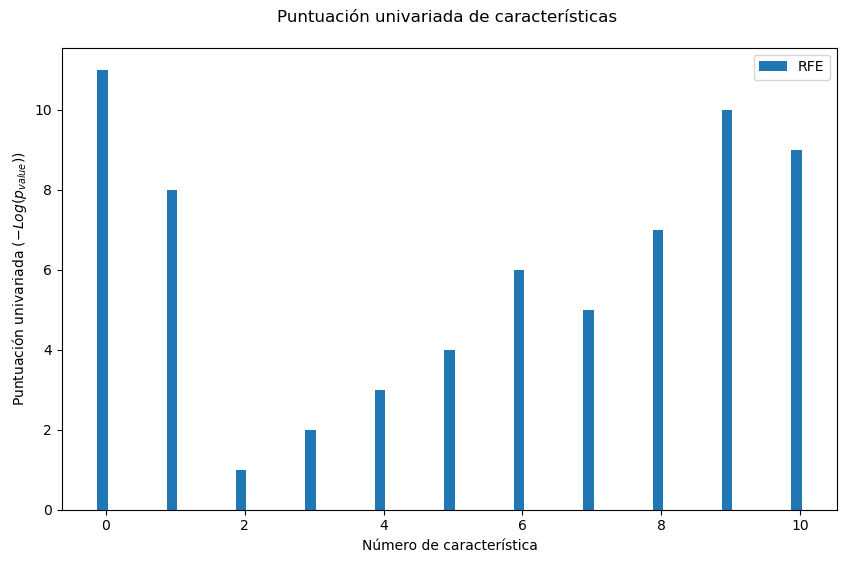

upsample


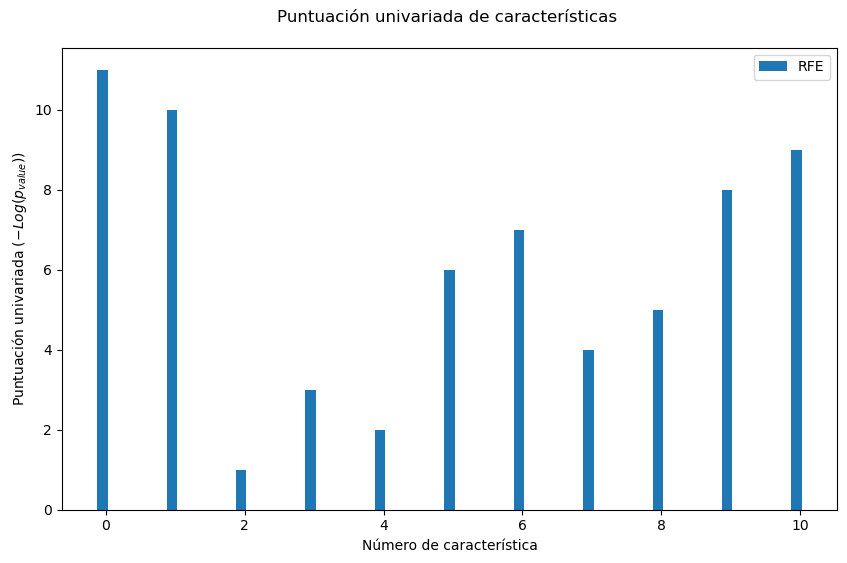

In [49]:
methods = {
        "RFE":None,
    }
    
feature_selection_all(data_standarized, methods)

### Comentario

En este caso se ordena las variables por orden de importancia (es decir que los valores de la grafica representan este orden ),tanto en upsample como en down sample el mas representativo es la variable 2 (age) por la contra las otras variables cambian de importanca. Tambien vemos un comportamiento similar al de filtros por lo que usaremos estos para seleción de varibles


### ***Modelado***

##### ***Cross-validation***

Para llevar a cabo la evaluación de nuestros modelos, implementamos la técnica GridSearchCV, la cual se basa en la validación cruzada con k=10 pliegues (teniendo en cuenta los conjuntos de entrenamiento y validación). Esta técnica realiza una búsqueda exhaustiva en anchura, considerando todas las combinaciones posibles de hiperparámetros. Posteriormente, para validar la efectividad de nuestros modelos, los comparamos con los datos de prueba y calculamos métricas importantes como precisión, F1-score, recall, exactitud y generamos la matriz de confusión. Además, construimos la curva ROC para una mejor comprensión del rendimiento del modelo.

En este proceso, utilizamos diccionarios para organizar y facilitar la comparación de los valores obtenidos de manera clara y eficiente.

In [98]:

def eval_model(y_test, y_pred, model_name='Model'):
    """
    Evalúa el modelo e imprime las métricas de rendimiento.
    """
    # Calcula las métricas
    precision = precision_score(y_test, y_pred, pos_label='Yes')
    recall = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{model_name}:\n Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}\n")
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #print('La matriz de confusión obtenida por el : \n{}'.format(conf_matrix_rf))
    # Preparar datos para la curva ROC
    y_test_num = y_test.map({'No': 0, 'Yes': 1})
    y_pred_num = np.where(y_pred == 'Yes', 1, 0)
    
    TP = conf_matrix[1, 1]
    
    fpr, tpr, _ = roc_curve(y_test_num, y_pred_num)
    roc_auc = auc(fpr, tpr)

    # Dibujar la curva ROC
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
     # Curva ROC
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic')
    ax[0].legend(loc="lower right")

    # Matriz de confusión
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax[1], cmap="Blues", cbar=False)
    ax[1].set_xlabel('Predicted labels')
    ax[1].set_ylabel('True labels')
    ax[1].set_title('Confusion Matrix')
    ax[1].xaxis.set_ticklabels(['Negative', 'Positive'])
    ax[1].yaxis.set_ticklabels(['Negative', 'Positive'])
    fig.suptitle('{}'.format(model_name))
    plt.tight_layout()
    plt.show()

    return  {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "TP": TP,
        "ROC_AUC": roc_auc
        }

def evaluate_hyperparameters(X_train, y_train, model, hyperparameters, model_name='./models/rf_model_v2.pkl'):
    """
    Evalúa los hiperparámetros utilizando GridSearchCV y guarda el mejor modelo.
    """
    grid_search = GridSearchCV(model, hyperparameters, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
    np.random.seed(SEED_VALUE)
    grid_search.fit(X_train, y_train)
    
    with open(model_name, 'wb') as file:
        pickle.dump(grid_search, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    return grid_search, model_name

def select_model(model_name, params={}):
    """
    Selecciona y devuelve un modelo basado en el nombre del modelo.
    """
    if model_name == 'random_forest':
        model = RandomForestClassifier(**params)
    elif model_name == 'svm':
        model = SVC(**params)
    elif model_name == 'logistic_regression':
        model = LogisticRegression(**params)
    elif model_name=='knn':
        model=KNeighborsClassifier(**params)
    else:
        raise ValueError("Model name not recognized.")
    return model

def compare_models(name,best_indexes,best_hyperparams, X_train, y_train, X_test, y_test,other=''):
    
    """
    Compara modelos utilizando los mejores hiperparámetros encontrados.
    """
    results = {}
    for index, params in enumerate(best_hyperparams):
        model = select_model(name, params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = eval_model(y_test, y_pred, model_name=f"{name}_{other} with params\n {params}")
        results[best_indexes[index]] = {'y_pred': y_pred, 
                                        'metrics': metrics,
                                        'model': model} 
    return results

def compare_model_sets(X_train, y_train, X_test, y_test, models, num_top_models=5, reselect=False,
                       other='',strategy=''):
    
    """
    Evalúa y compara un conjunto de modelos.
    """
    results={}
    for name, hyperparameters in models.items():
        file_path = f'./models_split/{strategy}_{name}_{other}.pkl'
        
        if os.path.exists(file_path) and not(reselect):
            with open(file_path, 'rb') as file:
                model_grid_search = pickle.load(file)
        else:
            model = select_model(name)
            model_grid_search, _ = evaluate_hyperparameters(X_train, y_train, model, 
                                                            hyperparameters, model_name=file_path)
        

        best_indexes = np.argsort(model_grid_search.cv_results_['rank_test_score'])[:num_top_models]
        best_hyperparams = [model_grid_search.cv_results_['params'][i] for i in best_indexes]
        #compare_models(name, best_hyperparams, X_train, y_train, X_test, y_test,other)
        y_pred = compare_models(name, best_indexes, best_hyperparams, X_train, y_train,
                                X_test, y_test,f'{strategy}_{other}')
        results[name] = {'predictions': y_pred} 
        
    return results


In [99]:
def compare_datas_and_selected(X_train,y_train,X_test,y_test,models,star_num=1, num_label=2,strategy='',list_feature=[]):
    results={}
    selected_features={}
    if len(list_feature)<=0:
        print(list_feature)
        for n in range(star_num,num_label):
            name=f"SelectKBest_{n}"
            selected_features[name] = feature_selection(X_train, y_train, SelectKBest(f_classif, k=n) ,name )

            X_train_selected = X_train[selected_features[name]]
            X_test_selected = X_test[selected_features[name]]
            X_train_selected

            results[n] = compare_model_sets(X_train_selected,y_train,X_test_selected,y_test,models,
                                            num_top_models=5,other=name,strategy=strategy)
    else:
        for n,feature_selected in enumerate(list_feature):
            name='_'.join(feature_selected)
            selected_features[name] = feature_selected #feature_selection(X_train, y_train, SelectKBest(f_classif, k=n) ,name )

            X_train_selected = X_train[selected_features[name]]
            X_test_selected = X_test[selected_features[name]]
            X_train_selected

            results[n] = compare_model_sets(X_train_selected,y_train,X_test_selected,y_test,models,
                                            num_top_models=5,other=name,strategy=strategy)
            
    return results    

In [100]:
def compare_all_data(data,models,star_num=1, num_label=2,list_feature=[]):
    #feature_selection=[]
    results = {}
    for strategy, dataset in data.items():
        print(strategy)
        results[strategy] = compare_datas_and_selected(dataset['X_train'].copy(), dataset['y_train'].copy(),
                                   dataset['X_test'].copy(), dataset['y_test'].copy(),models,
                                  star_num, num_label,strategy,list_feature)
    return results
        

In [101]:
hiperparametros = {
     'n_estimators': np.arange(10, 101, 10),
     'criterion': ['gini', 'entropy', 'log_loss'],
     'max_depth':  [None, 10, 50, 100],
     'min_samples_split': np.arange(2, 20, 4),
     'min_samples_leaf': np.arange(1, 10, 2),
     'max_features': [None, 'sqrt', 'log2'],
     'bootstrap': [True, False], 
}
hiperparametros_lg = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['newton-cg', 'newton-cholesky','lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]

}

# Definiendo el espacio de hiperparámetros
hiperparametros_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.5, 1.0]
}

hiperparametros_knn = {
    'n_neighbors': range(3, 10),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(20, 41, 10),
    'p': [1, 2]
}



models={'random_forest':hiperparametros,
       'logistic_regression':hiperparametros_lg,
        'svm':hiperparametros_svc,
        'knn':hiperparametros_knn,}    

In [ ]:
results1=compare_all_data(data_standarized,models ,1,7)

In [ ]:
hiperparametros_rf = {
     'n_estimators': [10,20,30,40,50,70,80,100],
     'criterion': ['gini', 'entropy', 'log_loss'],
     'max_depth':  [None, 10, 50, 100],
     'min_samples_split': np.arange(2, 20, 4),
     'min_samples_leaf': np.arange(1, 10, 2),
     'max_features': [None, 'sqrt', 'log2'],
     'bootstrap': [True], 
}
models={'random_forest':hiperparametros_rf,
       'logistic_regression':hiperparametros_lg,
        'svm':hiperparametros_svc,
        'knn':hiperparametros_knn,} 
 
features_selected=[['age','bmi'],['age','avg_glucose_level'],['age','bmi','work_type'],['age','avg_glucose_level','work_type']]
result2=compare_all_data(data_standarized,models ,1,7,list_feature=features_selected)

In [104]:

    
def get_dataframe_from_results(results, df_results):
    data = []
    for key, value in results.items():
        for model, model_info in value.items():
            for pred_key, pred_value in model_info.items():
                # grid_search = pred_value['model_grid_search']
                for pred in pred_value['predictions'].items():
                    row = {'dataset': key, 
                            'n_features_sel': model,
                            'classifier': pred_key,
                            # 'grid_search_obj': grid_search,
                            'best_index': pred[0],
                            'y_pred': pred[1]['y_pred'],
                            'accuracy': pred[1]['metrics']['accuracy'], 
                            'recall': pred[1]['metrics']['recall'],
                            'precision': pred[1]['metrics']['precision'], 
                            'TP': pred[1]['metrics']['TP'], 
                            'ROC_AUC': pred[1]['metrics']['ROC_AUC'], 
                            'model': pred[1]['model']}
                    data.append(row)
    if df_results.empty:
        df_results = pd.DataFrame(data)
    else:
       new_data = pd.DataFrame(data)
       df_results = pd.concat([df_results, new_data], ignore_index=True)

    return df_results


In [105]:
df_results = pd.DataFrame()
df_results = get_dataframe_from_results(results1, df_results)

In [106]:
df_results.head(5)

dataset  n_features_sel     classifier  best_index  \
0  downsample               1  random_forest        3140   
1  downsample               1  random_forest        6320   
2  downsample               1  random_forest        4180   
3  downsample               1  random_forest        1150   
4  downsample               1  random_forest        4632   

                                              y_pred  accuracy  recall  \
0  [No, No, No, No, No, No, Yes, No, No, No, No, ...  0.671233    0.80   
1  [No, No, No, Yes, No, No, Yes, No, No, No, No,...  0.678082    0.76   
2  [No, No, No, No, No, No, Yes, No, No, No, No, ...  0.659491    0.82   
3  [No, No, No, No, No, No, Yes, No, No, No, No, ...  0.687867    0.78   
4  [No, No, No, No, No, No, Yes, No, No, No, No, ...  0.657534    0.80   

   precision  TP   ROC_AUC                                              model  
0   0.109290  40  0.732305  (DecisionTreeClassifier(criterion='entropy', m...  
1   0.107042  38  0.716934  (DecisionTreeClassifier(criterion='log_loss', ...  
2   0.107895  41  0.735617  (DecisionTreeClassifier(criterion='entropy', m...  
3   0.112392  39  0.731564  (DecisionTreeClassifier(max_depth=10, max_feat...  
4   0.105263  40  0.725103  (DecisionTreeClassifier(criterion='entropy', m...

In [107]:
df_results.shape

(240, 11)

### ***Discusión de resultados***

Como hemos visto, contamos con una cantidad muy grande de modelos entrenados, por lo tanto debemos filtrar solamente los que mejor resultado han dado. 

Para comparar, utilizaremos principalmente el recall ya que en el dominio del dataset lo que nos interesa es aumentar esta métrica lo máximo posible ya que no queremos indicarle a un paciente que no tendrá un ataque cuando sí lo vaya a tener poniendo así su vida en peligro. 

En primer lugar, comenzaremos viendo en una gráfica de puntos la exactitud de los modelos de cada clasificador diferenciandolos por color dependendiendo del clasificador al que pertenezcan. 

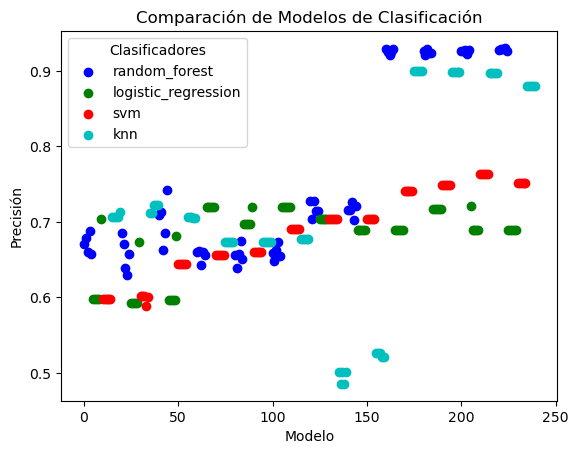

In [108]:
scores = []
classifiers = df_results['classifier'].unique()

# Definir colores para cada clasificador
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_map = {classifier: color for classifier, color in zip(classifiers, colors)}

for i, row in df_results.iterrows():
    if row['dataset'] == 'downsample':
        y_test = data_standarized['downsample']['y_test']
    else:
        y_test = data_standarized['upsample']['y_test']   
    y_pred = row['y_pred']
    scores.append(row['accuracy'])

# Crear el gráfico de puntos
x = range(len(df_results))
for classifier in classifiers:
    indices = [i for i, x in enumerate(df_results['classifier']) if x == classifier]
    plt.scatter(indices, [scores[i] for i in indices], color=color_map[classifier], label=classifier)

plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Comparación de Modelos de Clasificación')
plt.legend(title="Clasificadores")
plt.show()


Vemos como la mayoría de los modelos se concentran en el rango entre una exactitud de 0.6 y 0.8, pero hay unos pocos modelos con un accuracy entre 0.85 y 0.95 siendo estos últmos mayoritariamente del clasificador KNN y Random Forest. 

De modos similar veamos las curvas ROC de todos los modelos. Vemos como prácticamente todos los modelos tienen un AUC similar y no muy óptimo.

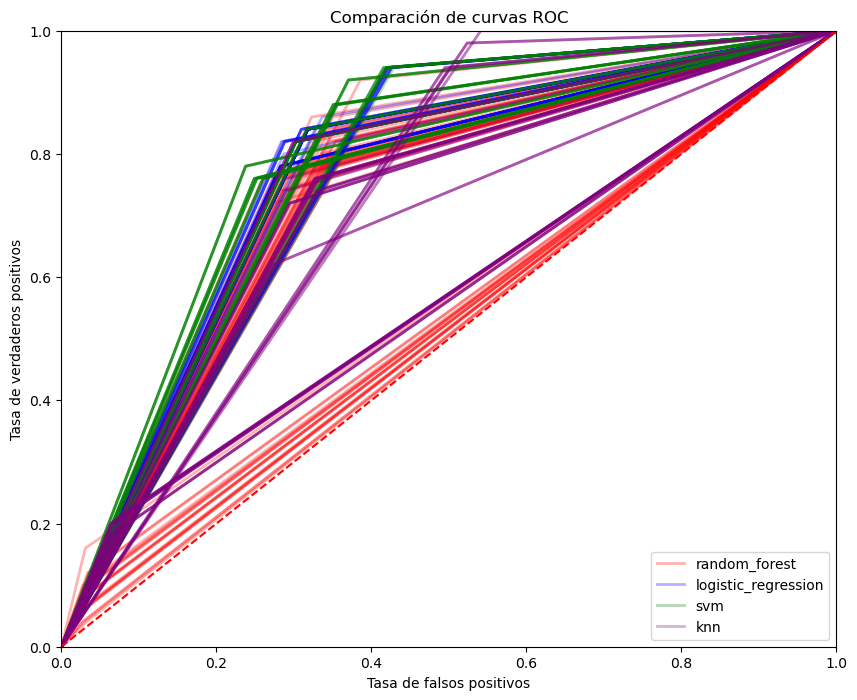

In [109]:
classifiers = df_results['classifier'].unique()
colors = {'random_forest': 'red', 
          'logistic_regression': 'blue',
          'knn': 'purple',
          'svm': 'green'}

plt.figure(figsize=(10, 8))

for classifier in classifiers:
    first_time = True
    for i, row in df_results[df_results['classifier'] == classifier].iterrows():
        if row['dataset'] == 'downsample':
            y_test = data_standarized['downsample']['y_test']
        else:
            y_test = data_standarized['upsample']['y_test'] 
        y_pred = row['y_pred']

        y_test_num = y_test.map({'No': 0, 'Yes': 1})
        y_pred_num = np.where(y_pred == 'Yes', 1, 0)

        fp, tp, th = roc_curve(y_test_num, y_pred_num)
        if first_time:
            plt.plot(fp, tp, lw=2, alpha=0.3, color=colors[classifier], label=f'{classifier}')
            first_time = False
        else:
            plt.plot(fp, tp, lw=2, alpha=0.3, color=colors[classifier])
    
plt.title('Comparación de curvas ROC')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Tasa de verdaderos positivos')
plt.xlabel('Tasa de falsos positivos')    
plt.legend(loc='lower right')
plt.show()


Ahora pasaremos a incidir en los mejores modelos, concretamente el top 5 de los modelos con menor cantidad de falsos negativos o con mayor recall, de forma que podamos compararlos y ver las diferencias entre ellos.   

In [110]:
df_results.sort_values(by='recall', ascending=False, inplace=True)

In [111]:
top_5_models = df_results.head(5).reset_index(drop=True)
top_5_models

dataset  n_features_sel classifier  best_index  \
0  upsample               1        knn         117   
1  upsample               1        knn         119   
2  upsample               1        knn         229   
3  upsample               1        knn          61   
4  upsample               1        knn         230   

                                              y_pred  accuracy  recall  \
0  [No, No, No, Yes, No, No, Yes, Yes, No, No, Ye...  0.485323    1.00   
1  [No, No, No, Yes, No, No, Yes, Yes, No, No, Ye...  0.485323    1.00   
2  [No, No, No, Yes, No, No, Yes, Yes, No, No, Ye...  0.500978    0.98   
3  [No, No, No, Yes, No, No, Yes, Yes, No, No, Ye...  0.500978    0.98   
4  [No, No, No, Yes, No, No, Yes, Yes, No, No, Ye...  0.500978    0.98   

   precision  TP   ROC_AUC                                              model  
0   0.086806  50  0.729424  KNeighborsClassifier(algorithm='ball_tree', n_...  
1   0.086806  50  0.729424  KNeighborsClassifier(algorithm='ball_tree', n_...  
2   0.087814  49  0.728169  KNeighborsClassifier(algorithm='kd_tree', leaf...  
3   0.087814  49  0.728169  KNeighborsClassifier(leaf_size=40, n_neighbors...  
4   0.087814  49  0.728169  KNeighborsClassifier(algorithm='kd_tree', leaf...

Mostraremos para cada modelo el clasificador en cuestión, los parámetros empleados para entrenar el modelo, las características seleccionadas y además mostraremos de nuevo la gráfica con la curva ROC y la matriz de confusión. 

In [112]:
def print_results(df):
    for i, row in df.iterrows():
        print('Modelo ', i+1, ' de ', len(df), sep='')
        model = row['model']
        print('-> Clasificador: ', row['classifier'])
        print('-> Parmámetros empleados: ', model.get_params())
        print('-> Características empleadas: ', model.feature_names_in_)
        print('-> Dataset empleado: ', row['dataset'])
        
        if row['dataset'] == 'downsample':
            y_test = data_standarized['downsample']['y_test']
        else:
            y_test = data_standarized['upsample']['y_test'] 
        y_pred = row['y_pred']
        eval_model(y_test, y_pred)
        print('\n')


Modelo 1 de 5
-> Clasificador:  knn
-> Parmámetros empleados:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
-> Características empleadas:  ['age']

Model:
 Precision: 0.087, Recall: 1.000, F1-Score: 0.160, Accuracy: 0.485



<Figure size 640x480 with 0 Axes>

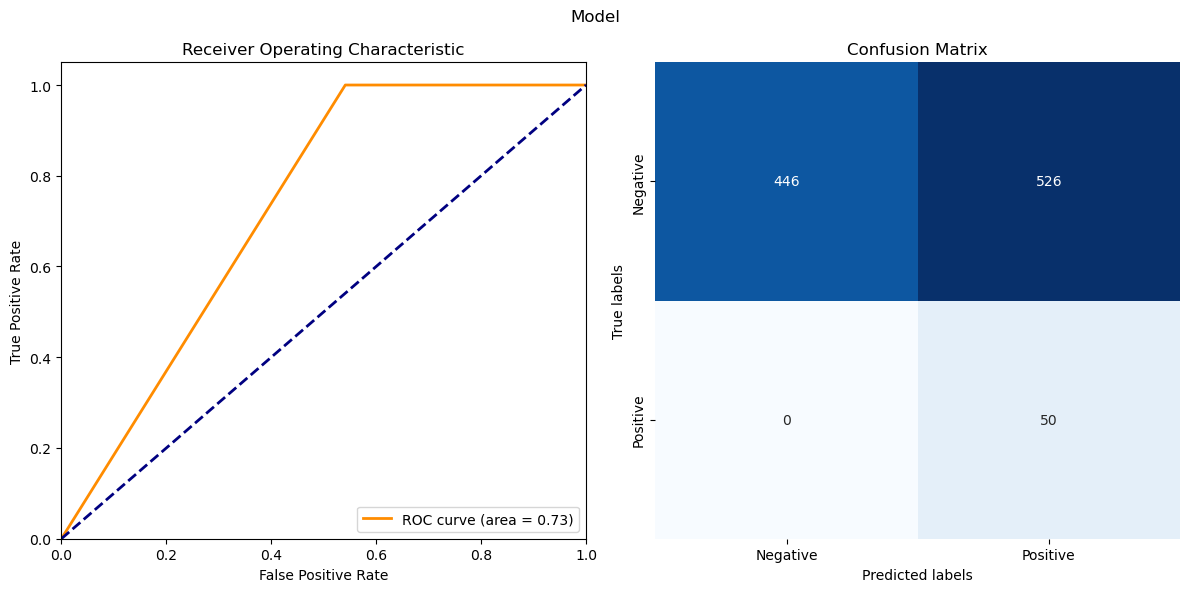



Modelo 2 de 5
-> Clasificador:  knn
-> Parmámetros empleados:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
-> Características empleadas:  ['age']

Model:
 Precision: 0.087, Recall: 1.000, F1-Score: 0.160, Accuracy: 0.485



<Figure size 640x480 with 0 Axes>

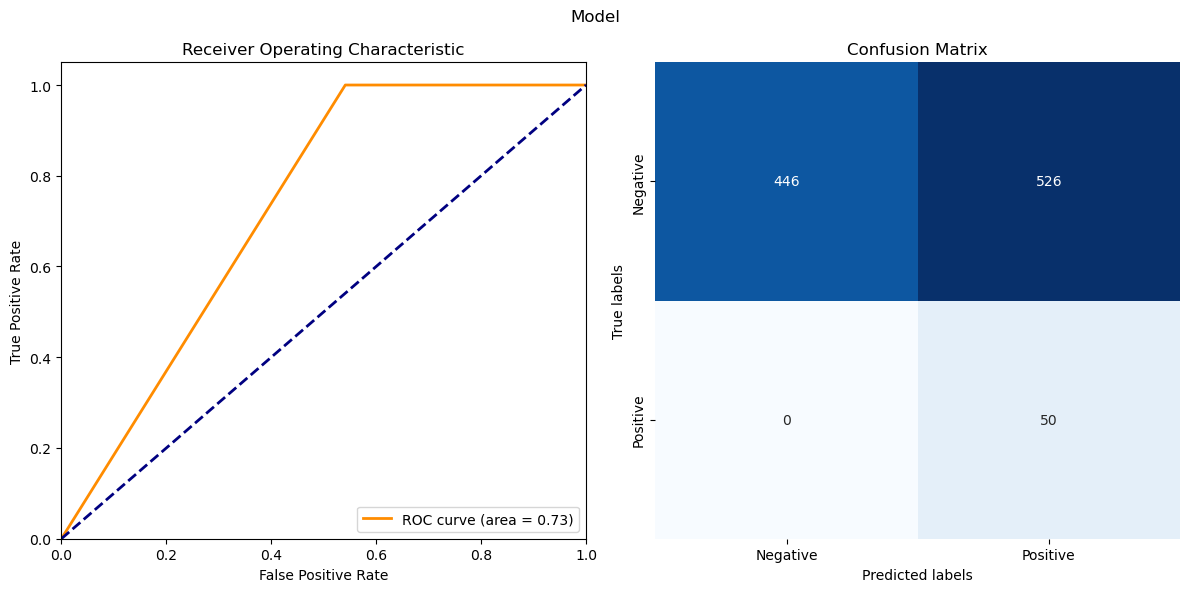



Modelo 3 de 5
-> Clasificador:  knn
-> Parmámetros empleados:  {'algorithm': 'kd_tree', 'leaf_size': 40, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
-> Características empleadas:  ['age']

Model:
 Precision: 0.088, Recall: 0.980, F1-Score: 0.161, Accuracy: 0.501



<Figure size 640x480 with 0 Axes>

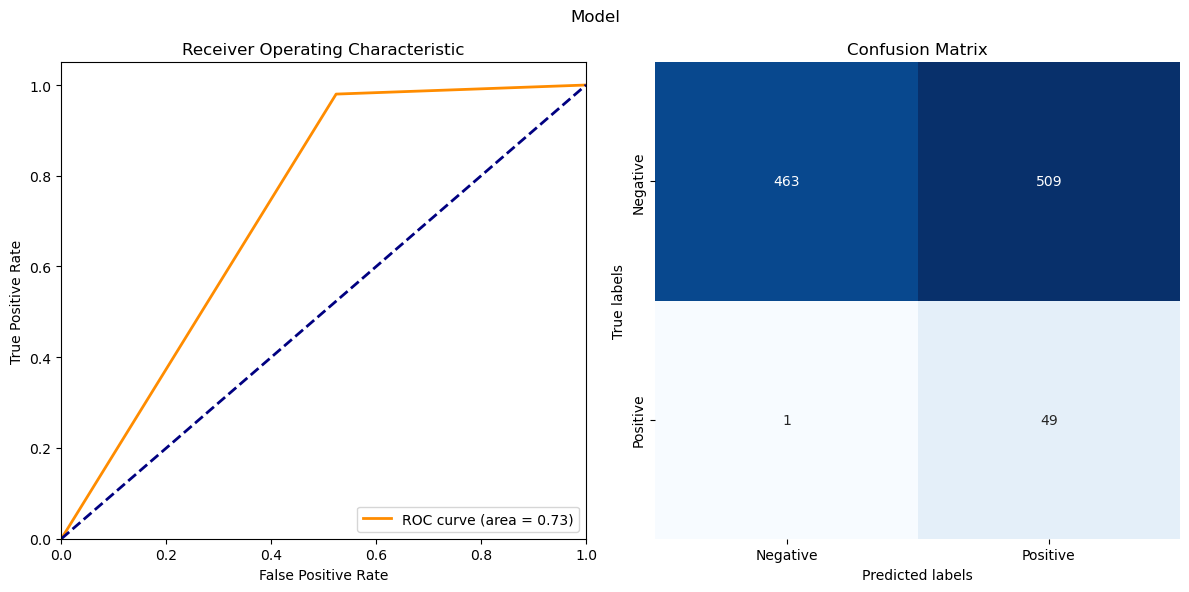



Modelo 4 de 5
-> Clasificador:  knn
-> Parmámetros empleados:  {'algorithm': 'auto', 'leaf_size': 40, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
-> Características empleadas:  ['age']

Model:
 Precision: 0.088, Recall: 0.980, F1-Score: 0.161, Accuracy: 0.501



<Figure size 640x480 with 0 Axes>

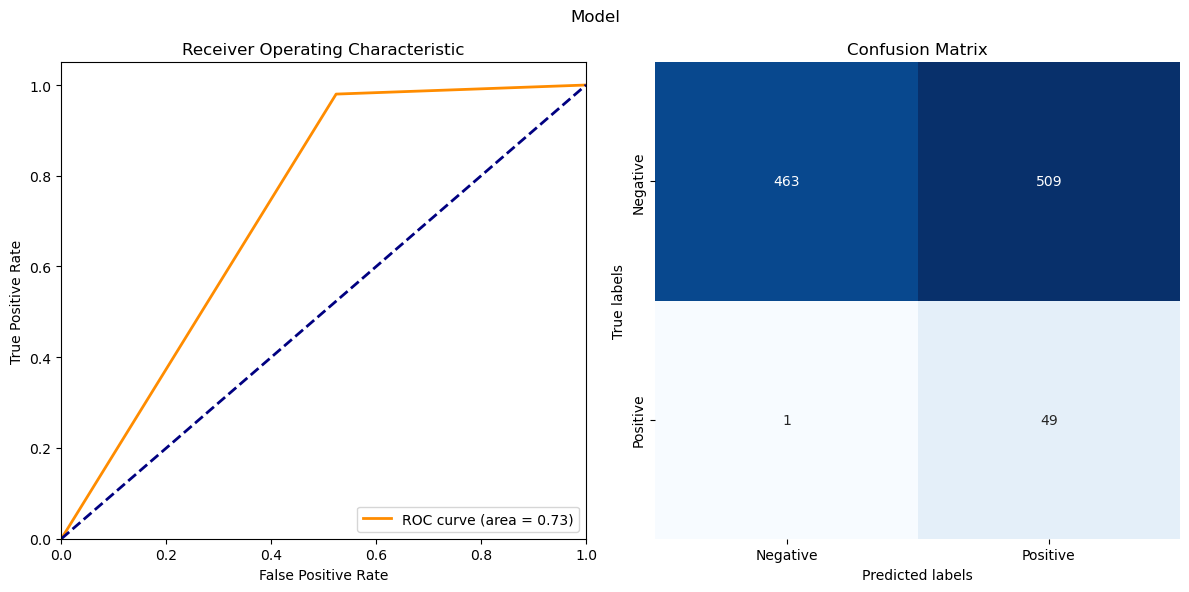



Modelo 5 de 5
-> Clasificador:  knn
-> Parmámetros empleados:  {'algorithm': 'kd_tree', 'leaf_size': 40, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
-> Características empleadas:  ['age']

Model:
 Precision: 0.088, Recall: 0.980, F1-Score: 0.161, Accuracy: 0.501



<Figure size 640x480 with 0 Axes>

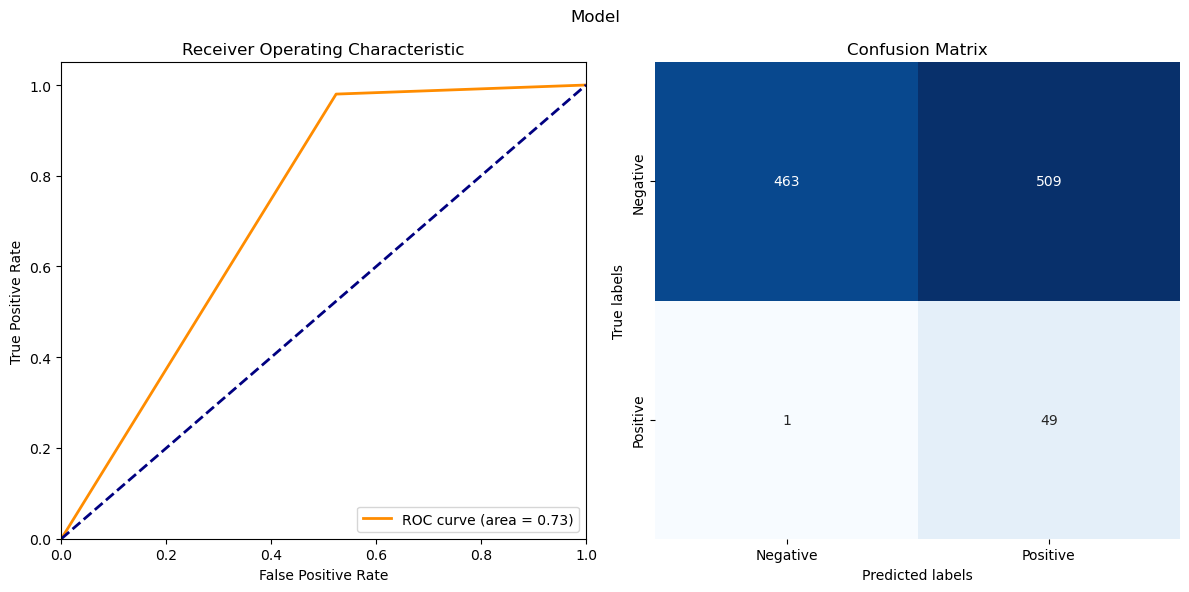

In [113]:
print_results(top_5_models)

Los 5 modelos pertenecen al clasificador KNN y han sido entrenados con el dataset `[[[X]]]`. Vemos también como ha dado estos resultados empleando únicamente una característica que es la edad de los pacientes, *age*. Asimismo, el AUC es bastante alto, con un valor de 0.73 en todos los casos pero el accuracy ya no es tan alto ya que apenas ha alcanzado un 0.5 en los 5 modelos. 

Ahora, representaremos los 5 modelos en un gráfico de barras:

In [ ]:
def plot_comparative(df, title):    
    algorithms= df['classifier']
    scores = df['recall']
    y_pos = np.arange(1, len(algorithms)+1, 1)
    colors = ("purple","green","orange","blue", "red")
    plt.figure(figsize=(18,10))
    plt.bar(y_pos, scores,color=colors)
    plt.xticks(y_pos, algorithms, fontsize=18)
    plt.yticks(np.arange(0.00, 1.01, step=0.05))
    plt.xlabel('Classifier')  
    plt.ylabel('Recall')
    plt.grid()
    plt.suptitle(title,fontsize=28)
    plt.show()

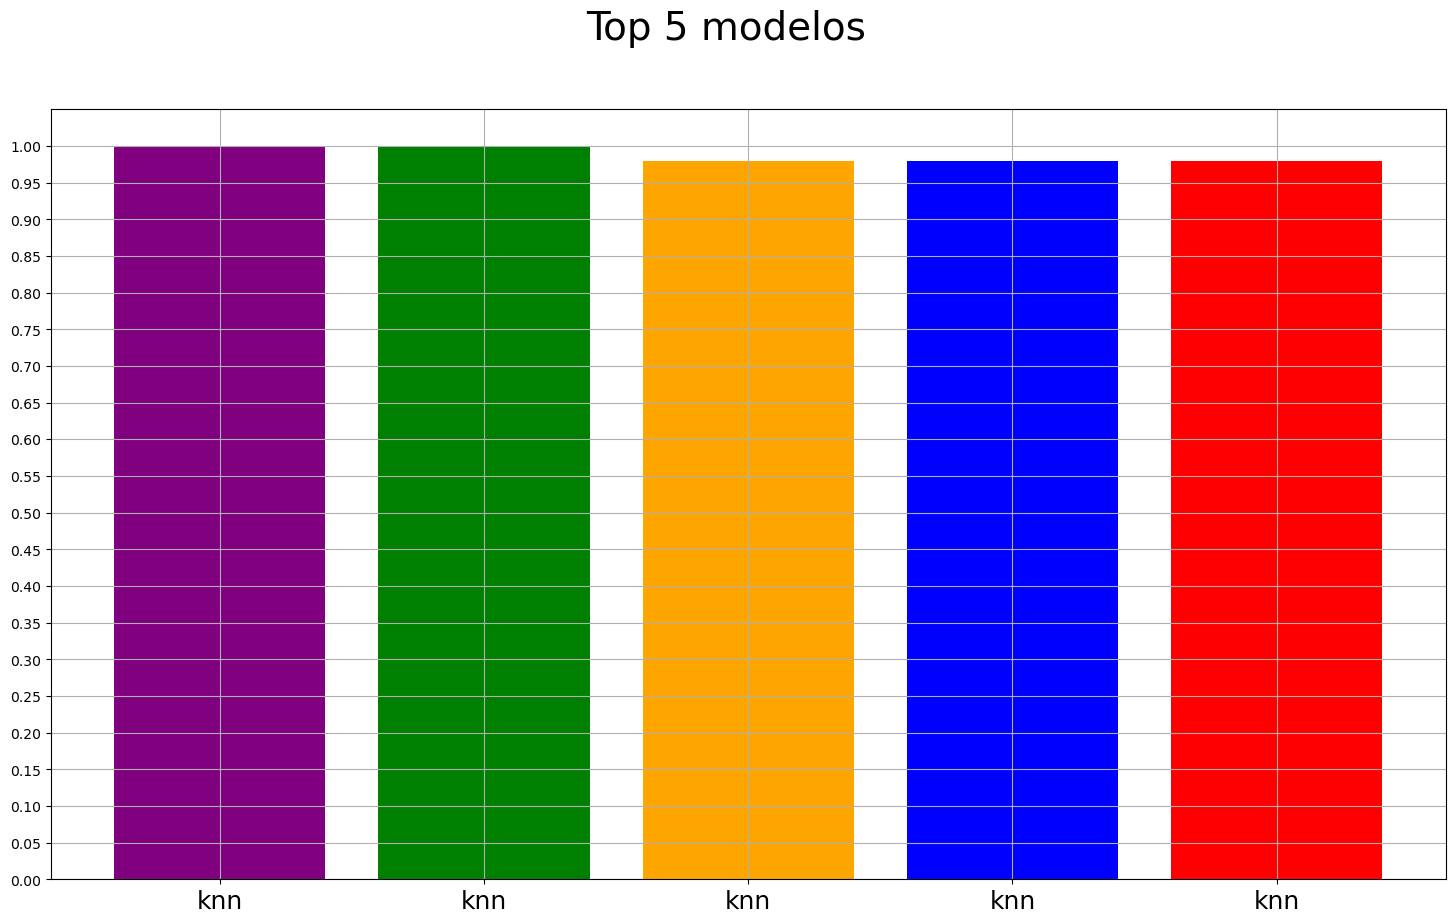

In [122]:
plot_comparative(top_5_models, "Top 5 modelos")

Vemos como prácticamente no hay diferencia en el recall de los 5 modelos por lo que podríamos seleccionar uno de ellos en base al tiempo de ejecución, por ejemplo. 

Ahora, pasaremos a comparar el mejor modelo para cada uno de los clasificadores estudiados:

In [125]:
top_1_models_per_classifier = df_results.loc[df_results.groupby('classifier')['TP'].idxmax()].sort_values(by='accuracy', ascending=False).reset_index(drop=True)
top_1_models_per_classifier

dataset  n_features_sel           classifier  best_index  \
0  downsample               2        random_forest        8991   
1  downsample               2                  svm          97   
2  downsample               3  logistic_regression         585   
3    upsample               1                  knn         117   

                                              y_pred  accuracy  recall  \
0  [No, No, No, Yes, No, No, Yes, Yes, No, No, No...  0.629159    0.92   
1  [No, No, No, Yes, No, No, Yes, Yes, No, No, No...  0.600783    0.94   
2  [No, No, No, Yes, No, No, Yes, Yes, No, No, No...  0.595890    0.94   
3  [No, No, No, Yes, No, No, Yes, Yes, No, No, Ye...  0.485323    1.00   

   precision  TP   ROC_AUC                                              model  
0   0.109264  46  0.767099  (DecisionTreeClassifier(criterion='log_loss', ...  
1   0.103982  47  0.761667       SVC(C=1, coef0=0.5, degree=2, kernel='poly')  
2   0.102845  47  0.759095     LogisticRegression(C=0.01, solver='liblinear')  
3   0.086806  50  0.729424  KNeighborsClassifier(algorithm='ball_tree', n_...

Modelo 1 de 4
-> Clasificador:  random_forest
-> Parmámetros empleados:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 18, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
-> Características empleadas:  ['age' 'ever_married']

Model:
 Precision: 0.109, Recall: 0.920, F1-Score: 0.195, Accuracy: 0.629



<Figure size 640x480 with 0 Axes>

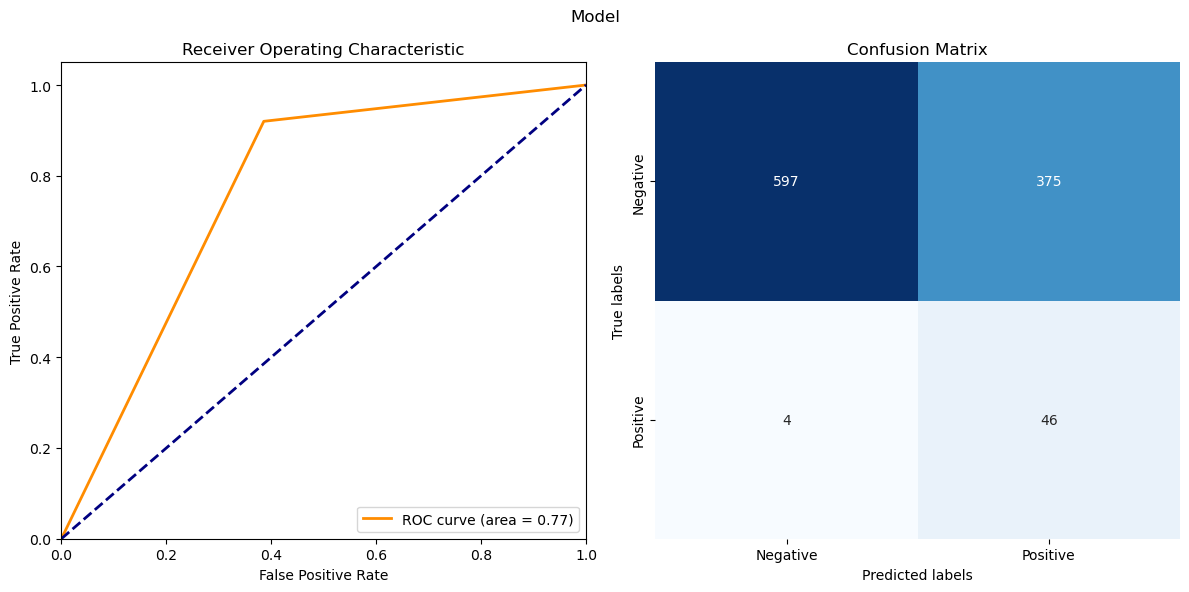



Modelo 2 de 4
-> Clasificador:  svm
-> Parmámetros empleados:  {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.5, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
-> Características empleadas:  ['age' 'ever_married']

Model:
 Precision: 0.104, Recall: 0.940, F1-Score: 0.187, Accuracy: 0.601



<Figure size 640x480 with 0 Axes>

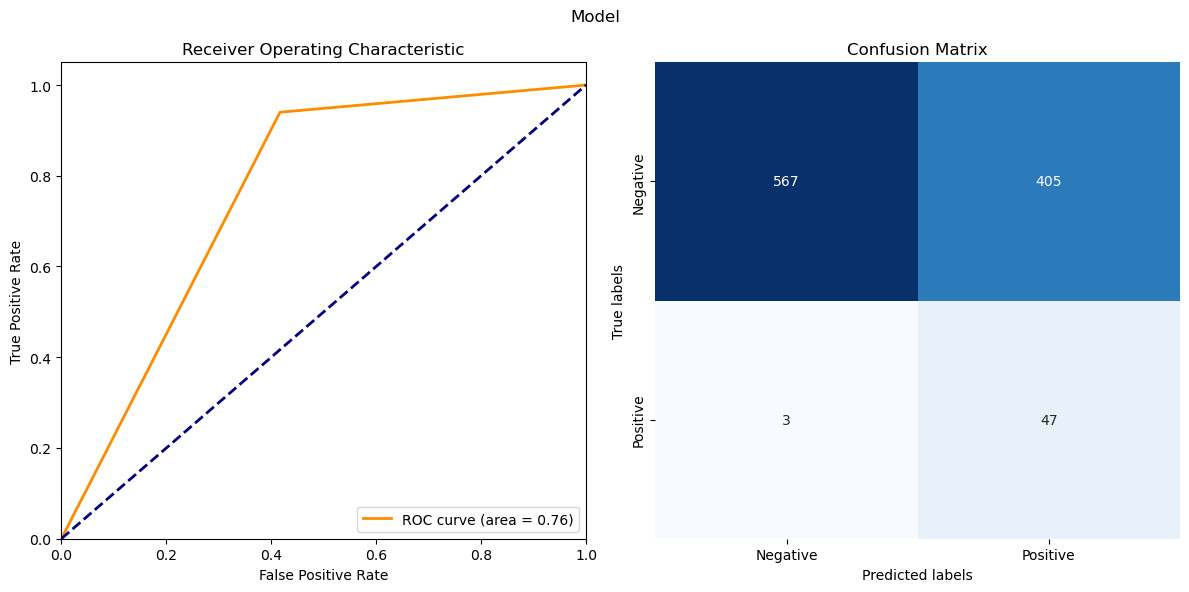



Modelo 3 de 4
-> Clasificador:  logistic_regression
-> Parmámetros empleados:  {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-> Características empleadas:  ['age' 'hypertension' 'ever_married']

Model:
 Precision: 0.103, Recall: 0.940, F1-Score: 0.185, Accuracy: 0.596



<Figure size 640x480 with 0 Axes>

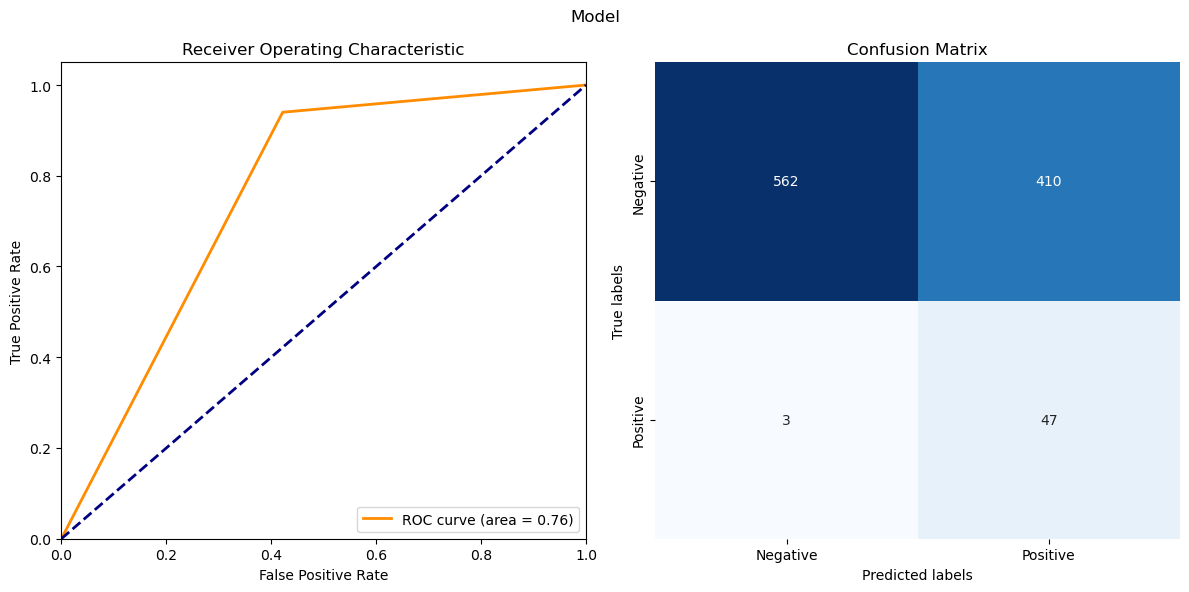



Modelo 4 de 4
-> Clasificador:  knn
-> Parmámetros empleados:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
-> Características empleadas:  ['age']

Model:
 Precision: 0.087, Recall: 1.000, F1-Score: 0.160, Accuracy: 0.485



<Figure size 640x480 with 0 Axes>

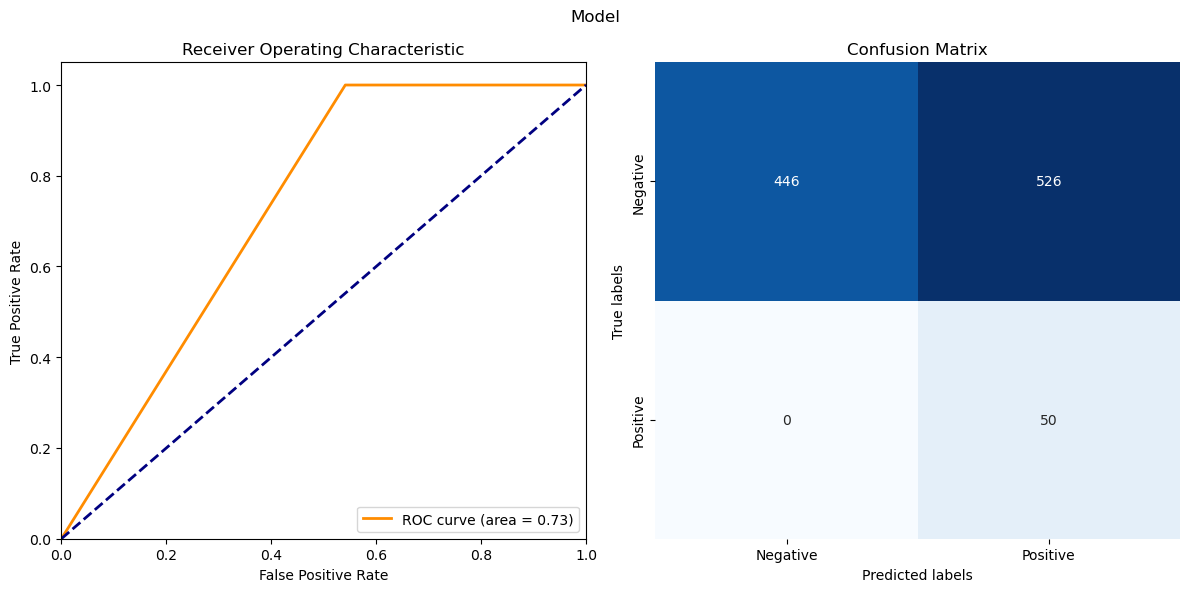

In [126]:
print_results(top_1_models_per_classifier)

Podemos observar que cada uno de los modelos emplea un conjunto de características diferentes y han sido entrenados con datasets diferentes `[[[CORREGIR SI NO ES ASÍ]]]`. Podemos ver también que KNN pese a tener el mayor recall (siguiente figura) es el de menor AUC y accuracy. De todas formas, para el problema en cuestión, KNN sigue siendo la mejor opción. 

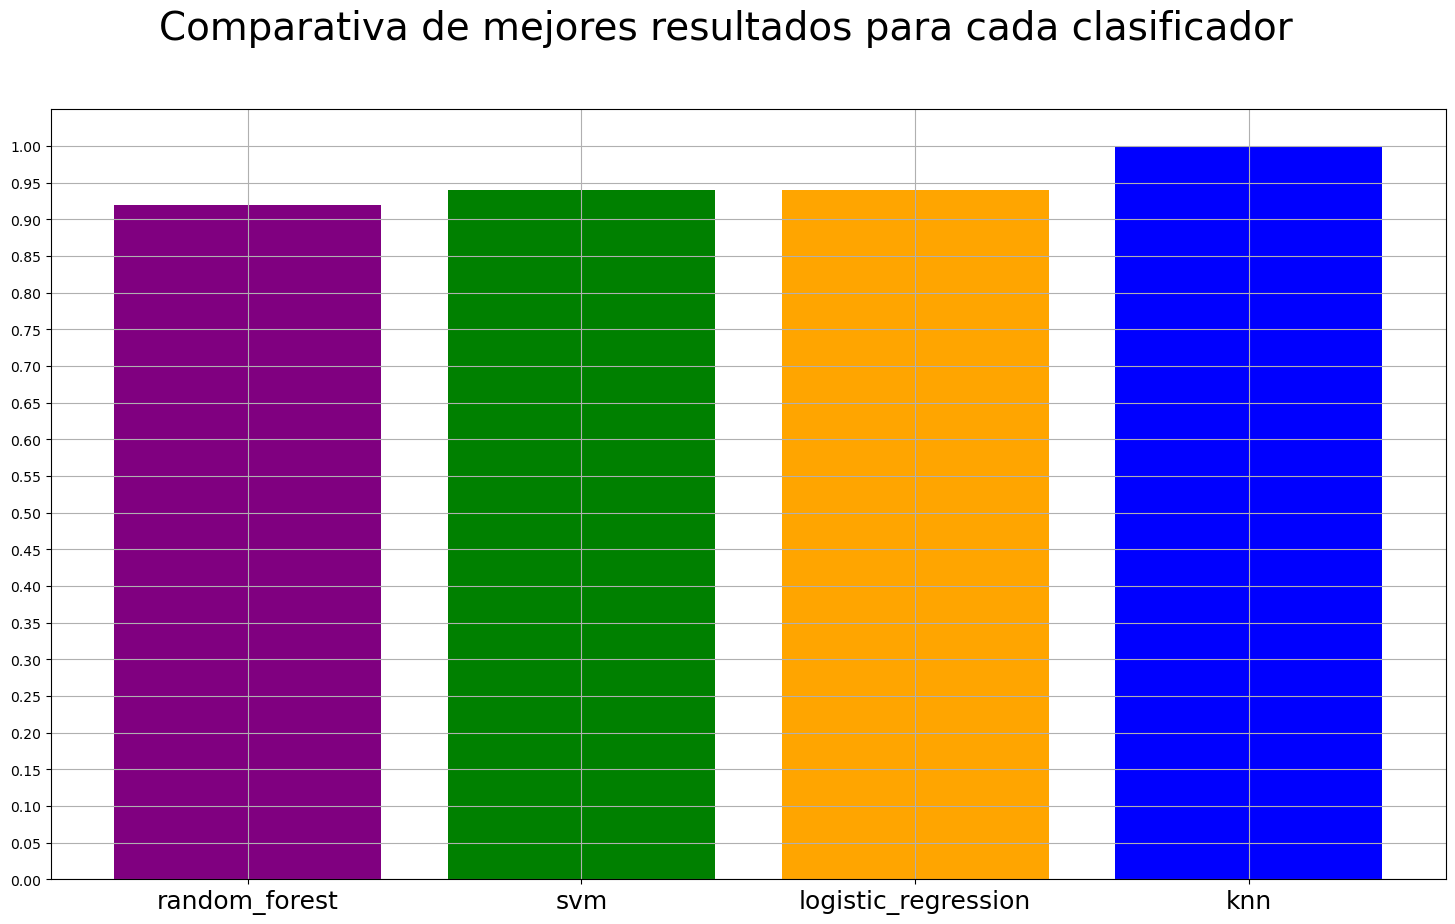

In [127]:
plot_comparative(top_1_models_per_classifier, "Comparativa de mejores resultados para cada clasificador")

### ***Conclusiones***

   **Downsampling vs. Upsampling**: Se compara el desempeño de downsampling y upsampling en términos de métricas de evaluación como recall y falsos positivos/negativos. Se observa que upsamplig resulta en un mejor recall al tener menos falsos negativos, mientras que downsamplig conduce a demasiados falsos positivos, lo que no es deseable. para una variable en el caso de mas de 3 upsamplig cambia a clasificar casi todo como negativo.

   **Uso de la variable 'age'**: Se destaca que la variable 'age' es bastante descriptiva por sí sola, ya que puede describir adecuadamente los verdaderos positivos, aunque también genera falsos positivos. Sin embargo, la cantidad de falsos negativos es baja, lo que hace que este comportamiento sea más deseable.

   **Comparación entre modelos de clasificación ('age')**: Se evalúan diferentes modelos (random forest, KNN, SVM, logistic regression) en términos de su comportamiento en la detección de falsos negativos y falsos positivos. Se concluye que tanto random forest como KNN tienen un comportamiento más deseable al minimizar los falsos negativos, aunque también tienen más falsos positivos. Por otro lado, SVM y logistic regression son mejores en la detección de falsos positivos, pero tienen más falsos negativos.

   **Más de dos variable para upsampling y downsampling**: Se señala que al usar dos ('age','get_married','avg_glucose') de una variable para upsampling, el modelo KNN no funciona correctamente, ya que tiende a clasificar la mayoría de los casos como negativos, lo que aumenta el accuracy pero no el recall. En este caso, logistic regression tiene un mejor rendimiento.